# A modified CenterNet architecture for oriented bounding box detection

See the CenterNet official repo : https://github.com/xingyizhou/CenterNet

The main goal of this repo is to demonstrate how we can adapt the CenterNet ideas to multiple cars from a Bird Eye View as oriented bounding boxes. We train our network to predict a heatmap of the <b>box center</b> that is refined with an <b>offset map</b>. Then <b>bounding boxes dimensions</b> are regressed to get length and width of the vehicle. Orientation angle is also inferred with 2 heatmaps, <b>one for cosine and for sine</b>. In terms of architecture, another difference with CenterNet is that we are not using any upsampling layers, since detection of small objects doesnt require a global information of the original image.

# Summary
- import and display your dataset
- define utility functions to draw heatmaps and how we can recover oriented bounding boxes from main heatmap, offset heatmaps, width and height heatmaps, and sine/cosine heatmaps
- make a Pytorch dataset for training and validation
- define the model with a Resnet-18 backbone
- define our loss
- train the network
- display a few predictions on the validation dataset

# Imports

In [1]:
import cv2
import numpy as np
import os
import xml.etree.ElementTree as ET
import json
from typing import Dict, List
import re
import pandas as pd
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from collections import OrderedDict
from sklearn.model_selection import train_test_split
import timm
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchsummary import summary
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
assert torch.cuda.is_available()
import math
from glob import glob
from torchvision.ops import nms
#import albumentations as A
from functools import partial
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
# Not always necessary depending on your hardware/GPU
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"



def check_excess_coordinates(file_path):
    """
    Check if the XML file contains more than x5 y5 coordinates.
    """
    tree = ET.parse(file_path)
    root = tree.getroot()

    for obj in root.findall('object'):
        bndbox = obj.find('polygon')
        if bndbox is not None:
            coordinates = [child.tag for child in bndbox]
            # Checking if there are more than 10 tags (x1, y1, ..., x5, y5)
            if len(coordinates) > 10:
                return True
    return False

def main(folder_path):
    """
    Scan through all XML files in the folder and list those to be deleted.
    """
    files_to_delete = []
    for file in os.listdir(folder_path):
        if file.endswith('.xml'):
            file_path = os.path.join(folder_path, file)
            if check_excess_coordinates(file_path):
                files_to_delete.append(file_path)

    return files_to_delete

# Usage example (replace 'path_to_your_folder' with the actual folder path)
files_to_delete = main('C:/Users/John/Desktop/notebooks/datasets/number-license-plate.v5i.voc/train')
print("Files to delete:", files_to_delete)

# Optional: Uncomment the following lines to actually delete the files
for file_path in files_to_delete:
    os.remove(file_path)
    os.remove(file_path.replace(".xml",".jpg"))


In [2]:
# Here we dont assume that our images are 512x512 we prefer to use HD images (more common)
input_width = 512 
input_height = 512

# Model scale is 16, meaning that in the model prediction, we have heatmaps of dimensions 80 x 45
MODEL_SCALE = 4 #32 #16 #4

# Batch size for training --> if your hardware supports it, try to increase this value
batch_size = 4 #24

In [3]:
def extract_coordinates(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    all_objects_coords = []
    all_names = []
    size = root.find('size')
    image_width = int(size.find('width').text) 
    image_height = int(size.find('height').text)
    for obj in root.findall('object'):
        coords = {}

        # Extracting coordinates from bndbox
        bndbox = obj.find('bndbox')
        name = obj.find('name').text
        if bndbox is not None:
            coords['xmin'] = bndbox.find('xmin').text if bndbox.find('xmin') is not None else None
            coords['ymin'] = bndbox.find('ymin').text if bndbox.find('ymin') is not None else None
            coords['xmax'] = bndbox.find('xmax').text if bndbox.find('xmax') is not None else None
            coords['ymax'] = bndbox.find('ymax').text if bndbox.find('ymax') is not None else None

        # Extracting coordinates from polygon
        # polygon = obj.find('polygon')
        # if polygon is not None:
        #     for i in range(1, 5):
        #         x_tag, y_tag = f'x{i}', f'y{i}'
        #         coords[x_tag] = polygon.find(x_tag).text if polygon.find(x_tag) is not None else None
        #         coords[y_tag] = polygon.find(y_tag).text if polygon.find(y_tag) is not None else None

        all_objects_coords.append(coords)
        all_names.append(name)

    return [all_objects_coords,all_names,image_width, image_height]

In [4]:
def extract_coordinates_gt(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    all_objects_coords = []
    all_names = []
    size = root.find('size')
    image_width = int(size.find('width').text) 
    image_height = int(size.find('height').text)
    extension = os.path.splitext(file_path)[1]
    
    with open("/home/rivian/Desktop/mAP/input/ground-truth/" + file_path.split("/")[-1].replace(extension,".txt"),"w") as f:
        for obj in root.findall('object'):
            coords = {}
    
            # Extracting coordinates from bndbox
            bndbox = obj.find('bndbox')
            name = obj.find('name').text
            if bndbox is not None:
                coords['xmin'] = bndbox.find('xmin').text if bndbox.find('xmin') is not None else None
                coords['ymin'] = bndbox.find('ymin').text if bndbox.find('ymin') is not None else None
                coords['xmax'] = bndbox.find('xmax').text if bndbox.find('xmax') is not None else None
                coords['ymax'] = bndbox.find('ymax').text if bndbox.find('ymax') is not None else None
                paramswrite = name + " " + coords['xmin'] + " " + coords["ymin"] + " " + coords["xmax"] + " " + coords["ymax"]
                f.write(paramswrite)
                f.write("\n")
            

        # Extracting coordinates from polygon
        # polygon = obj.find('polygon')
        # if polygon is not None:
        #     for i in range(1, 5):
        #         x_tag, y_tag = f'x{i}', f'y{i}'
        #         coords[x_tag] = polygon.find(x_tag).text if polygon.find(x_tag) is not None else None
        #         coords[y_tag] = polygon.find(y_tag).text if polygon.find(y_tag) is not None else None

        all_objects_coords.append(coords)
        all_names.append(name)

    return [all_objects_coords,all_names,image_width, image_height]

In [5]:
def convert_to_target_format(target,transformed_shape):
  """Converts a list of bounding boxes and class labels to target_ format.

  Args:
      target: A list of lists, where each inner list contains bounding box coordinates
              and a class label (e.g., [[xmin, ymin, xmax, ymax, 'class'], ...]

  Returns:
      A list containing a dictionary for each bounding box and a separate list for class labels,
      along with the image width and height. The format matches the `target_` variable you provided.
  """
  target_formatted = []
  labels = []
  for box in target:
    xmin, ymin, xmax, ymax, label = box
    # Convert coordinates to floats (assuming they are integers)
    target_formatted.append({
        'xmin': float(xmin),
        'ymin': float(ymin),
        'xmax': float(xmax),
        'ymax': float(ymax)
    })
    labels.append(label)


  return [target_formatted, labels,transformed_shape[1],transformed_shape[0]]

In [6]:
def sort_coordinates(coord_dict):
    # Extracting the coordinates into a list of tuples
    coords = [(float(coord_dict[f'x{i}']), float(coord_dict[f'y{i}'])) for i in range(1, 5)]
    # Sorting the coordinates based on x and then y values
    sort_y = sorted(coords, key=lambda coord: coord[1])
    lowest_2_ymin = sort_y[:2]
    top_left,top_right = sorted(lowest_2_ymin, key=lambda coord: coord[0])
    highest_ymax = sort_y[2:]
    bottom_left,bottom_right = sorted(highest_ymax, key=lambda coord: coord[0])

    return {
        'top_left': top_left,
        'top_right': top_right,
        'bottom_left': bottom_left,
        'bottom_right': bottom_right
    }

In [7]:
def draw_gaussian(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0:  # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap

def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def gaussian_radius(det_size, min_overlap=0.7):
    height, width = det_size

    a1 = 1
    b1 = (height + width)
    c1 = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1 = (b1 + sq1) / 2

    a2 = 4
    b2 = 2 * (height + width)
    c2 = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2 = (b2 + sq2) / 2

    a3 = 4 * min_overlap
    b3 = -2 * min_overlap * (height + width)
    c3 = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3 = (b3 + sq3) / 2
    return min(r1, r2, r3)

def draw_umich_gaussian(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap


In [8]:
# Make heatmaps using the utility functions from the centernet repo
def draw_msra_gaussian(heatmap, center, sigma=2):
    tmp_size = sigma * 6
    mu_x = int(center[0])
    mu_y = int(center[1])
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = br[0] - ul[0]
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
      heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
      g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    
    assert heatmap[mu_y, mu_x] == 1 # Center value must be 1
    return heatmap

# Offsets along x and y are between 0 and 1 and correct quantization errors from center heatmap
def draw_offset(offset, x, y):
    offset[0, int(y), int(x)] = x - int(x)
    offset[1, int(y), int(x)] = y - int(y)
    return offset

In [9]:
def pool_nms(heat, kernel = 3):
    pad = (kernel - 1) // 2

    hmax = nn.functional.max_pool2d(heat, (kernel, kernel), stride=1, padding=pad)
    keep = (hmax == heat).float()
    return heat * keep




def decode_bbox(pred_hms, pred_whs, pred_offsets, confidence=0.3, cuda=True):
    #-------------------------------------------------------------------------#
    #   当利用512x512x3图片进行coco数据集预测的时候
    #   h = w = 128 num_classes = 80
    #   Hot map热力图 -> b, 80, 128, 128, 
    #   进行热力图的非极大抑制，利用3x3的卷积对热力图进行最大值筛选
    #   找出一定区域内，得分最大的特征点。
    #-------------------------------------------------------------------------#
    pred_hms = pool_nms(pred_hms)
    
    b, c, output_h, output_w = pred_hms.shape
    detects = []
    #-------------------------------------------------------------------------#
    #   只传入一张图片，循环只进行一次
    #-------------------------------------------------------------------------#
    for batch in range(b):
        #-------------------------------------------------------------------------#
        #   heat_map        128*128, num_classes    热力图
        #   pred_wh         128*128, 2              特征点的预测宽高
        #                                           在预测过程的前处理以及后处理视频中讲的有点小问题，不是调整参数，就是宽高
        #   pred_offset     128*128, 2              特征点的xy轴偏移情况
        #-------------------------------------------------------------------------#
        heat_map    = pred_hms[batch].permute(1, 2, 0).view([-1, c])
        pred_wh     = pred_whs[batch].permute(1, 2, 0).view([-1, 2])
        pred_offset = pred_offsets[batch].permute(1, 2, 0).view([-1, 2])

        yv, xv      = torch.meshgrid(torch.arange(0, output_h), torch.arange(0, output_w))
        #-------------------------------------------------------------------------#
        #   xv              128*128,    特征点的x轴坐标
        #   yv              128*128,    特征点的y轴坐标
        #-------------------------------------------------------------------------#
        xv, yv      = xv.flatten().float(), yv.flatten().float()
        if cuda:
            xv      = xv.cuda()
            yv      = yv.cuda()

        #-------------------------------------------------------------------------#
        #   class_conf      128*128,    特征点的种类置信度
        #   class_pred      128*128,    特征点的种类
        #-------------------------------------------------------------------------#
        class_conf, class_pred  = torch.max(heat_map, dim = -1)
        mask                    = class_conf > confidence

        #-----------------------------------------#
        #   取出得分筛选后对应的结果
        #-----------------------------------------#
        pred_wh_mask        = pred_wh[mask]
        pred_offset_mask    = pred_offset[mask]
        if len(pred_wh_mask) == 0:
            detects.append([])
            continue     

        #----------------------------------------#
        #   计算调整后预测框的中心
        #----------------------------------------#
        xv_mask = torch.unsqueeze(xv[mask] + pred_offset_mask[..., 0], -1)
        yv_mask = torch.unsqueeze(yv[mask] + pred_offset_mask[..., 1], -1)
        #----------------------------------------#
        #   计算预测框的宽高
        #----------------------------------------#
        half_w, half_h = pred_wh_mask[..., 0:1] / 2, pred_wh_mask[..., 1:2] / 2
        #----------------------------------------#
        #   获得预测框的左上角和右下角
        #----------------------------------------#
        bboxes = torch.cat([xv_mask - half_w, yv_mask - half_h, xv_mask + half_w, yv_mask + half_h], dim=1)
        bboxes[:, [0, 2]] /= output_w
        bboxes[:, [1, 3]] /= output_h
        detect = torch.cat([bboxes, torch.unsqueeze(class_conf[mask],-1), torch.unsqueeze(class_pred[mask],-1).float()], dim=-1)
        detects.append(detect)

    return detects

def centernet_correct_boxes(box_xy, box_wh, input_shape, image_shape, letterbox_image):
    #-----------------------------------------------------------------#
    #   把y轴放前面是因为方便预测框和图像的宽高进行相乘
    #-----------------------------------------------------------------#
    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]
    input_shape = np.array(input_shape)
    image_shape = np.array(image_shape)

    if letterbox_image:
        #-----------------------------------------------------------------#
        #   这里求出来的offset是图像有效区域相对于图像左上角的偏移情况
        #   new_shape指的是宽高缩放情况
        #-----------------------------------------------------------------#
        new_shape = np.round(image_shape * np.min(input_shape/image_shape))
        offset  = (input_shape - new_shape)/2./input_shape
        scale   = input_shape/new_shape

        box_yx  = (box_yx - offset) * scale
        box_hw *= scale

    box_mins    = box_yx - (box_hw / 2.)
    box_maxes   = box_yx + (box_hw / 2.)
    boxes  = np.concatenate([box_mins[..., 0:1], box_mins[..., 1:2], box_maxes[..., 0:1], box_maxes[..., 1:2]], axis=-1)
    boxes *= np.concatenate([image_shape, image_shape], axis=-1)
    return boxes

def postprocess(prediction, need_nms, image_shape, input_shape, letterbox_image, nms_thres=0.4):
    output = [None for _ in range(len(prediction))]
    
    #----------------------------------------------------------#
    #   预测只用一张图片，只会进行一次
    #----------------------------------------------------------#
    for i, image_pred in enumerate(prediction):
        detections      = prediction[i]
        if len(detections) == 0:
            continue
        #------------------------------------------#
        #   获得预测结果中包含的所有种类
        #------------------------------------------#
        unique_labels   = detections[:, -1].cpu().unique()

        if detections.is_cuda:
            unique_labels = unique_labels.cuda()
            detections = detections.cuda()

        for c in unique_labels:
            #------------------------------------------#
            #   获得某一类得分筛选后全部的预测结果
            #------------------------------------------#
            detections_class = detections[detections[:, -1] == c]
            if need_nms:
                #------------------------------------------#
                #   使用官方自带的非极大抑制会速度更快一些！
                #------------------------------------------#
                keep = nms(
                    detections_class[:, :4],
                    detections_class[:, 4],
                    nms_thres
                )
                max_detections = detections_class[keep]

                # #------------------------------------------#
                # #   按照存在物体的置信度排序
                # #------------------------------------------#
                # _, conf_sort_index = torch.sort(detections_class[:, 4], descending=True)
                # detections_class = detections_class[conf_sort_index]
                # #------------------------------------------#
                # #   进行非极大抑制
                # #------------------------------------------#
                # max_detections = []
                # while detections_class.size(0):
                #     #---------------------------------------------------#
                #     #   取出这一类置信度最高的，一步一步往下判断。
                #     #   判断重合程度是否大于nms_thres，如果是则去除掉
                #     #---------------------------------------------------#
                #     max_detections.append(detections_class[0].unsqueeze(0))
                #     if len(detections_class) == 1:
                #         break
                #     ious = bbox_iou(max_detections[-1], detections_class[1:])
                #     detections_class = detections_class[1:][ious < nms_thres]
                # #------------------------------------------#
                # #   堆叠
                # #------------------------------------------#
                # max_detections = torch.cat(max_detections).data
            else:
                max_detections  = detections_class
            
            output[i] = max_detections if output[i] is None else torch.cat((output[i], max_detections))

        if output[i] is not None:
            output[i]           = output[i].cpu().numpy()
            box_xy, box_wh      = (output[i][:, 0:2] + output[i][:, 2:4])/2, output[i][:, 2:4] - output[i][:, 0:2]
            output[i][:, :4]    = centernet_correct_boxes(box_xy, box_wh, input_shape, image_shape, letterbox_image)
    return output

In [10]:
def pred2box(hm, offset, regr, thresh=0.5):
    # make binding box from heatmaps
    # thresh: threshold for logits.
        
    # get center
    pred = hm > thresh
    pred_center = np.where(hm>thresh)
    
    # get regressions
    pred_r = regr[:,pred].T
    print(pred_r)
    print(regr[:,pred])
    #pred_angles = cos_sin_hm[:, pred].T
    
    #print("pred_angle", pred_angle)

    # wrap as boxes
    # [xmin, ymin, width, height]
    # size as original image.
    boxes = []
    scores = hm[pred]
    
    pred_center = np.asarray(pred_center).T
    #print(pred_r.shape)
    #print(pred_angles)
    #print(pred_angles.shape)
    
    for (center, b) in zip(pred_center, pred_r):
        #print(b)
        offset_xy = offset[:, center[0], center[1]]
        #angle = np.arctan2(pred_angle[1], pred_angle[0])
        arr = np.array([(center[1]+offset_xy[0])*MODEL_SCALE, (center[0]+offset_xy[1])*MODEL_SCALE, 
                        b[0]*MODEL_SCALE, b[1]*MODEL_SCALE])
        # Clip values between 0 and input_size
        #arr = np.clip(arr, 0, input_size)
        #print("Pred angle", i, pred_angle[i])
        # filter 
        #if arr[0]<0 or arr[1]<0 or arr[0]>input_size or arr[1]>input_size:
            #pass
        boxes.append(arr)
    return np.asarray(boxes), scores


def select(hm, threshold):
    """
    Keep only local maxima (kind of NMS).
    We make sure to have no adjacent detection in the heatmap.
    """

    pred = hm > threshold
    pred_centers = np.argwhere(pred)

    for i, ci in enumerate(pred_centers):
        for j in range(i + 1, len(pred_centers)):
            cj = pred_centers[j]
            if np.linalg.norm(ci - cj) <= 2:
                score_i = hm[ci[0], ci[1]]
                score_j = hm[cj[0], cj[1]]
                if score_i > score_j:
                    hm[cj[0], cj[1]] = 0
                else:
                    hm[ci[0], ci[1]] = 0

    return hm


# functions for plotting results
def showbox(img, hm, offset, regr, thresh=0.9):
    boxes, _ = pred2box(hm, offset, regr, thresh=thresh)
    
    sample = img

    for box in boxes:
        center = [int(box[0]), int(box[1])] 
        #cos_angle = np.cos(box[4])
        #sin_angle = np.sin(box[4])
        #rot = np.array([[cos_angle, sin_angle], [-sin_angle, cos_angle]])
        reg_w = int(box[2]) 
        reg_h = int(box[3])
        print(center)
        
        xmin = center[0] - (reg_w / 2)
        ymin = center[1] - (reg_h / 2)
        xmax = center[0] + (reg_w / 2)
        ymax = center[1] + (reg_h / 2)
        
        xmin = int(xmin)
        ymin = int(ymin)
        xmax = int(xmax)
        ymax = int(ymax)
        
        cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,255,255),2)
        # bottom_right = np.dot(rot, np.array([box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
        # top_right = np.dot(rot, np.array([box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
        # top_left = np.dot(rot, np.array([-box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
        # bottom_left = np.dot(rot, np.array([-box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
        
        # thickness = 3
        # cv2.line(sample, (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1])),
        #               (int(center[0]+top_right[0]), int(center[1]+top_right[1])),
        #               (0, 220, 0), thickness)
        # cv2.line(sample, (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1])),
        #               (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1])),
        #               (220, 220, 0), thickness)
        # cv2.line(sample, (int(center[0]+top_left[0]), int(center[1]+top_left[1])),
        #               (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1])),
        #               (220, 220, 0), thickness)
        # cv2.line(sample, (int(center[0]+top_left[0]), int(center[1]+top_left[1])),
        #               (int(center[0]+top_right[0]), int(center[1]+top_right[1])),
        #               (220, 220, 0), thickness)
    return sample


In [11]:
def scatter_gaussian_kernel(heatmap, bbox_icx, bbox_icy, bbox_w, bbox_h, alpha=0.54):
    eps = 1e-6
    heatmap_h, heatmap_w = heatmap.shape
    dtype = heatmap.dtype
    
    area_scale = ((bbox_w * bbox_h) ** 0.2)  # Adjust the exponent for finer control
    std_w = alpha * bbox_w / 6. * area_scale
    std_h = alpha * bbox_h / 6. * area_scale
    
    var_w = std_w ** 2
    var_h = std_h ** 2
    var_w = var_w + eps
    var_h = var_h + eps
    grid_x, grid_y = np.meshgrid(np.arange(heatmap_w, dtype=dtype), np.arange(heatmap_h, dtype=dtype))

    gaussian_kernel = np.exp(-((grid_x - bbox_icx)**2/(2. * var_w))-((grid_y - bbox_icy)**2/(2. * var_h)))
    gaussian_kernel[bbox_icy, bbox_icx] = 1.
    heatmap = np.maximum(heatmap, gaussian_kernel)
    return heatmap

In [12]:
# Heatmap function
# MODEL_SCALE = 16 ==> 1280 to 80, 720 ==> 45
folder = '/home/rivian/Desktop/Datasets/Boxes.v2i.voc/train_images'
xml_files = glob(folder+'/*.xml')
classes = []
for i in xml_files:
    target = extract_coordinates(i)
    for b in target[1]:
        if b.upper()  not in classes:
            classes.append(b.upper())

def make_hm_offset_regr_angle(path,target):
    hm = np.zeros([len(classes),input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    hm_all = np.zeros([input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    offset = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    regr = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    #corners = np.zeros([8, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    #cos_sin_hm = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    try:
        target_check = extract_coordinates(path)
    except:
        return hm, offset, regr , hm_all
        
    if len(target[0]) == 0:
        return hm, offset, regr , hm_all
    
    # choice of sigma is important here, if you are working with very tiny objects, you should decrease the sigma value
    
    for (c,n) in zip(target[0],target[1]):
        name = n
        width_image = target[2]
        height_image = target[3]
        xmin = float(c['xmin']) * (input_width / width_image)
        ymin = float(c['ymin']) * (input_height / height_image)
        xmax = float(c['xmax']) * (input_width / width_image)
        ymax =  float(c['ymax']) * (input_height / height_image)
        xmin = np.clip(xmin,0,512)
        ymin = np.clip(ymin,0,512)
        xmax = np.clip(xmax,0,512)
        ymax = np.clip(ymax,0,512)
        cx = (xmin + xmax) / 2
        cy = (ymin + ymax) / 2
        w = (xmax - xmin)
        h = (ymax - ymin)

#         sorted_coords = sort_coordinates(c)
#         top_left = float(sorted_coords['top_left'][0]) * (input_width / 640) ,float(sorted_coords['top_left'][1]) * (input_height / 640)
#         top_right = float(sorted_coords['top_right'][0]) * (input_width / 640) ,float(sorted_coords['top_right'][1]) * (input_height / 640) 
#         bottom_left = float(sorted_coords['bottom_left'][0])* (input_width / 640) ,float(sorted_coords['bottom_left'][1]) * (input_height / 640) 
#         bottom_right = float(sorted_coords['bottom_right'][0]) * (input_width / 640) ,float(sorted_coords['bottom_right'][1]) * (input_height / 640)
        
        cls = list(classes).index(name.upper())

        radius = gaussian_radius((math.ceil(h), math.ceil(w)))
        radius = max(0, int(radius))
        diameter = 2 * radius + 1
        sigma = diameter / 6


        draw_umich_gaussian(hm[cls], [int(cx/MODEL_SCALE), int(cy/MODEL_SCALE)],radius)
        # hm[cls] = draw_msra_gaussian(hm[cls], [int(c["x"]/MODEL_SCALE), int(c["y"]/MODEL_SCALE)], 
        #                         sigma=sigma)
        #hm[cls] = scatter_gaussian_kernel(hm[cls], int(cx/MODEL_SCALE), int(cy/MODEL_SCALE), int(w/MODEL_SCALE), int(h/MODEL_SCALE))
#         hm_all = draw_msra_gaussian(hm_all, [int(cx/MODEL_SCALE), int(cy/MODEL_SCALE)], 
#                                 sigma=sigma)
        
        assert 0 <= cx < input_width
        assert 0 <= cy < input_height
        offset = draw_offset(offset, cx/MODEL_SCALE, cy/MODEL_SCALE)
        
        # for i in range(-1, 2):
        #     for j in range(-1, 2):
        try:
            regr[0, int(cy/MODEL_SCALE), int(cx/MODEL_SCALE)] = w/MODEL_SCALE
            regr[1, int(cy/MODEL_SCALE), int(cx/MODEL_SCALE)] = h/MODEL_SCALE
            hm_all[int(cy/MODEL_SCALE), int(cx/MODEL_SCALE)] = 1
            
            
        except:
            pass
    return hm, offset, regr, hm_all#,corners


In [13]:
classes,len(classes)

(['BOX'], 1)

In [14]:
from collections import defaultdict

def xml_to_coco_json(xml_dir, output_json_path):
    coco_data = {
        "images": [],
        "type": "instances",
        "annotations": [],
        "categories": []
    }
    category_dict = {}
    annotation_id = 1

    # Process each XML file
    for xml_file in os.listdir(xml_dir):
        if xml_file.endswith('.xml'):
            tree = ET.parse(os.path.join(xml_dir, xml_file))
            root = tree.getroot()
            
            # Gather image data
            filename = root.find('filename').text
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)

            image_id = len(coco_data["images"]) + 1
            coco_data["images"].append({
                "id": image_id,
                "width": width,
                "height": height,
                "file_name": filename
            })
            
            # Process each object in the image
            for obj in root.findall('object'):
                category = obj.find('name').text
                if category not in category_dict:
                    category_dict[category] = len(category_dict) + 1
                    coco_data["categories"].append({
                        "id": category_dict[category],
                        "name": category
                    })
                
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                
                coco_data["annotations"].append({
                    "id": annotation_id,
                    "image_id": image_id,
                    "category_id": category_dict[category],
                    "bbox": [xmin, ymin, xmax - xmin, ymax - ymin],
                    "area": (xmax - xmin) * (ymax - ymin),
                    "iscrowd": 0
                })
                annotation_id += 1

    # Save to JSON
    with open(output_json_path, 'w') as json_file:
        json.dump(coco_data, json_file, indent=4)

    print(f"Converted annotations saved to {output_json_path}")

# Usage
#xml_directory = glob("/home/rivian/Desktop/Datasets/Boxes.v2i.voc/val_images/*.xml")
xml_to_coco_json("/home/rivian/Desktop/Datasets/Boxes.v2i.voc/val_images", 'val_output_coco.json')

Converted annotations saved to val_output_coco.json


In [15]:
cocoGt = COCO("val_output_coco.json")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [16]:
#[
#   {"image_id": 1, "category_id": 1, "bbox": [250, 240, 25, 35], "score": 0.85},
#   {"image_id": 2, "category_id": 2, "bbox": [240, 205, 55, 85], "score": 0.75}
# ]

In [17]:
for i in cocoGt.dataset["images"]:
    print(i)
    id_ = i["id"]
    fname = i["file_name"]
    print(fname)
    #print(id_)

{'id': 1, 'width': 640, 'height': 640, 'file_name': '795_box_jpg.rf.c81fd0f42d3e9bbecbb84ee53013f752.jpg'}
795_box_jpg.rf.c81fd0f42d3e9bbecbb84ee53013f752.jpg
{'id': 2, 'width': 640, 'height': 640, 'file_name': '915_box_jpg.rf.840abc56cc805b6375ccb74b9b329202.jpg'}
915_box_jpg.rf.840abc56cc805b6375ccb74b9b329202.jpg
{'id': 3, 'width': 640, 'height': 640, 'file_name': '960_box_jpg.rf.3c971d8cb900e6f5a3c5cdc6d207fc15.jpg'}
960_box_jpg.rf.3c971d8cb900e6f5a3c5cdc6d207fc15.jpg
{'id': 4, 'width': 640, 'height': 640, 'file_name': '1400_box_jpg.rf.22bab3638d2f557ccd3a765fc20eef22.jpg'}
1400_box_jpg.rf.22bab3638d2f557ccd3a765fc20eef22.jpg
{'id': 5, 'width': 640, 'height': 640, 'file_name': '1360_box_jpg.rf.1a1fce3a4fe9716501fbae6079e20ffc.jpg'}
1360_box_jpg.rf.1a1fce3a4fe9716501fbae6079e20ffc.jpg
{'id': 6, 'width': 640, 'height': 640, 'file_name': '875_box_jpg.rf.5a11c713e45ab12c0fa95250613c520d.jpg'}
875_box_jpg.rf.5a11c713e45ab12c0fa95250613c520d.jpg
{'id': 7, 'width': 640, 'height': 640, 'fi

for xml in xml_files:
    hm, offset, regr, hm_all,corners = make_hm_offset_regr_angle(xml)
    img = cv2.imread(xml.replace(".xml",".jpg"))
    img = cv2.resize(img,(128,128))
    plt.title(xml.split("\\")[-1])
    plt.imshow(img)
    plt.imshow(hm[0],alpha=0.5,cmap="jet")
    plt.show()
    

# Make Pytorch dataset with dataloader

In [18]:
# Split train-test by unique image ids, corresponding to image paths
folder = '/home/rivian/Desktop/Datasets/Boxes.v2i.voc/'
# gt_annos = glob(folder + "val_images/*.xml")
# for i in gt_annos:
#     extract_coordinates_gt(i)

train_id = glob(folder+"train_images/*.jpg") + glob(folder+"train_images/*.png")
val_id = glob(folder+"val_images/*.jpg") + glob(folder+"val_images/*.png")

In [19]:
# import shutil
# for i in val_id:
#     extension = os.path.splitext(i)[1]
#     name = i.split("/")[-1]
#     pth = "/home/rivian/Desktop/mAP/input/images-optional/" + name
#     shutil.copy(i,pth)
    
    

In [20]:
#[
#   {"image_id": 1, "category_id": 1, "bbox": [250, 240, 25, 35], "score": 0.85},
#   {"image_id": 2, "category_id": 2, "bbox": [240, 205, 55, 85], "score": 0.75}
# ]

In [21]:
def calc_det(model):
    #<class_name> <confidence> <left> <top> <right> <bottom>
    #files = glob(folder + "val_images/*.jpg") + glob(folder + "val_images/*.png")
    coco_format = []
    for i in cocoGt.dataset["images"]:     #for i in files:
        id_ = i["id"]
        img_ = folder + "val_images/" + i["file_name"]
        frame = cv2.imread(img_)
        image_shape = np.array(np.shape(frame)[0:2])
        #frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
        frame_show = frame.copy()
        frame = cv2.resize(frame,(input_width,input_height))
        
        frame = Normalize()(frame)
        frame = torch.tensor(frame).permute(-1,0,1)
        #extension = os.path.splitext(i)[1]
    
        try:
            with torch.no_grad():
                hm, offset, wh = model(frame.to(device).float().unsqueeze(0))
            offset = offset.cpu().numpy().squeeze(0)
            wh = wh.cpu().numpy().squeeze(0)
            hm = torch.sigmoid(hm) #.cpu().numpy()

            outputs = decode_bbox(hm,torch.tensor(wh[None]).cuda(),torch.tensor(offset[None]).cuda(),confidence=0.05)
            results = postprocess(outputs,True,[frame_show.shape[0], frame_show.shape[1]],image_shape, False, 0.3)
            top_label   = np.array(results[0][:, 5], dtype = 'int32')
            top_conf    = results[0][:, 4]
            top_boxes   = results[0][:, :4]
            for (conf,label,box) in zip(top_conf,top_label,top_boxes):
                ymin = box[0]
                xmin = box[1] 
                ymax = box[2] 
                xmax = box[3] 

                xmin = int(xmin)
                ymin = int(ymin)
                xmax = int(xmax)
                ymax = int(ymax)
                class_label = label
                name = classes[class_label]
                anno = {"image_id": id_, "category_id": int(class_label)+1, "bbox": [xmin, ymin, xmax-xmin, ymax-ymin], "score": float(conf)}
                coco_format.append(anno)
                # paramswrite = name+ " " + str(float(conf)) + " " + str(xmin) + " " + str(ymin) + " " + str(xmax) + " " + str(ymax)
                # f.write(paramswrite)
                # f.write("\n")
                
        except Exception as e:
            print(f"Could not infer an error occured: {e}")
            
    with open('detection_results.json', 'w') as file:
        json.dump(coco_format, file)
    #return coco_format
    


transform = A.Compose([
    A.RandomCrop(width=450, height=450,p=0.3),
    A.HorizontalFlip(p=0.3),
    A.RandomScale(scale_limit=(0.6,1.3),p=0.3),
    A.ColorJitter(p=0.3)
], bbox_params=A.BboxParams(format='pascal_voc'))
img = cv2.imread(val_id[0])
target_ = extract_coordinates(val_id[0].replace(".jpg",".xml"))
target = extract_coordinates(val_id[0].replace(".jpg",".xml"))
target = [[int(float(i["xmin"])),int(float(i["ymin"])),int(float(i["xmax"])),int(float(i["ymax"])),l]for (l,i) in zip(target[1],target[0])]
transformed = transform(image=img, bboxes=target)
img_transformed = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_shape = img_transformed.shape
img_transformed.shape

convert_to_target_format(transformed_bboxes,transformed_shape)

target

target_

l = A.Compose([
            A.RandomCrop(width=450, height=450,p=0.3),
            A.HorizontalFlip(p=0.3),
            A.RandomScale(scale_limit=(0.6,1.3),p=0.3),
            A.ColorJitter(p=0.3)
        ], bbox_params=A.BboxParams(format='pascal_voc'))

l[0].height=35

In [22]:
def target_transform_value_check(target):
    target_ = []
    for (l,i) in zip(target[1],target[0]):
        target_temp = []
        xmin = int(float(i["xmin"]))
        ymin = int(float(i["ymin"]))
        xmax = int(float(i["xmax"]))
        ymax = int(float(i["ymax"]))
        if (xmin < 0): xmin = 0
        if (xmax < 0): xmax = 0
        if (ymin <0): ymin = 0
        if (ymax <0): ymax = 0
        if (xmin >= xmax):
            xmax = xmin + 1
        if (ymin >= ymax):
            ymax = ymin + 1
        target_temp.append(xmin)
        target_temp.append(ymin)
        target_temp.append(xmax)
        target_temp.append(ymax)
        target_temp.append(l)
        target_.append(target_temp)
    return target_
        
        
    

In [23]:
# Resnet-18 expect normalized channels in input
class Normalize(object):
    def __init__(self):
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        self.norm = transforms.Normalize(self.mean, self.std)
    def __call__(self, image):
        image = image.astype(np.float32)/255
        axis = (0,1)
        image -= self.mean
        image /= self.std
        return image
    

class CarDataset(torch.utils.data.Dataset):
    def __init__(self, img_id,val, transform=None):
        self.img_id = img_id
        self.val = val
        if transform:
            self.transform = transform
        self.normalize = Normalize()
        # self.transform =  A.Compose([
        #     #A.RandomCrop(width=450, height=450,p=0.3),
        #     A.HorizontalFlip(p=0.4),
        #     A.RandomScale(scale_limit=(0.6,1.3),p=0.3),
        #     A.ColorJitter(p=0.3)
        # ], bbox_params=A.BboxParams(format='pascal_voc'))
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        if self.val == True: f_name = "val_images"
        else: f_name = "train_images" 
        #print(self.img_id[idx])
        img = cv2.imread(self.img_id[idx])
        extension = os.path.splitext(self.img_id[idx])[1]
        path = self.img_id[idx].replace(extension,".xml")
        try:
            target = extract_coordinates(path)
        except:
            img = cv2.resize(img,(input_width,input_height))
            img = self.normalize(img)
            img = img.transpose([2,0,1])
            hm, offset, regr,hm_all = make_hm_offset_regr_angle(path,extract_coordinates(path))
            return img, hm, offset, regr,hm_all
            
        # if (img.shape[0] < 450):
        #     self.transform[0].height=img.shape[0]
        # if (img.shape[1] < 450):
        #     self.transform[0].width=img.shape[1]
            
        # if f_name == "train_images":
        #     #target_transform = [[int(float(i["xmin"])),int(float(i["ymin"])),int(float(i["xmax"])),int(float(i["ymax"])),l]for (l,i) in zip(target[1],target[0])]
        #     target_transform = target_transform_value_check(target)
        #     transformed = self.transform(image=img, bboxes=target_transform)
        #     img = transformed['image']
        #     transformed_bboxes = transformed['bboxes']
        #     transformed_shape = img.shape
        #     target = convert_to_target_format(transformed_bboxes,transformed_shape)
        
        img = cv2.resize(img,(input_width,input_height))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        
        hm, offset, regr,hm_all = make_hm_offset_regr_angle(path,target)
        #assert(hm.shape == (128, 128))
        #assert(regr.shape == (2, 128, 128))
        #assert(angle.shape == (128, 128))
        return img, hm, offset, regr,hm_all


In [24]:
traindataset = CarDataset(train_id,val=False)
valdataset = CarDataset(val_id,val=True)


In [25]:
classes

['BOX']

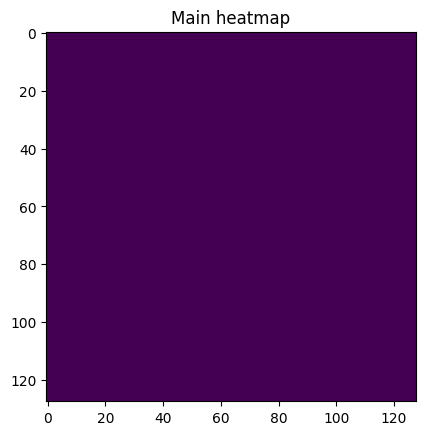

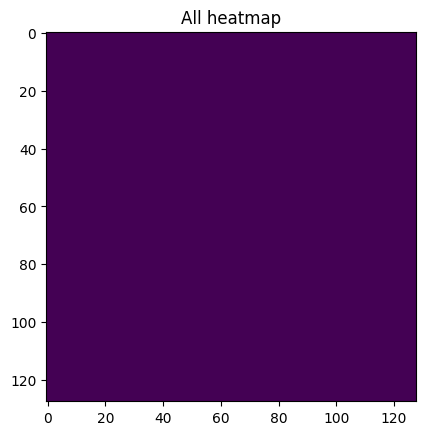

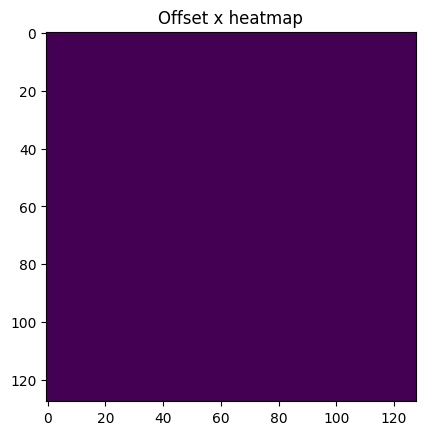

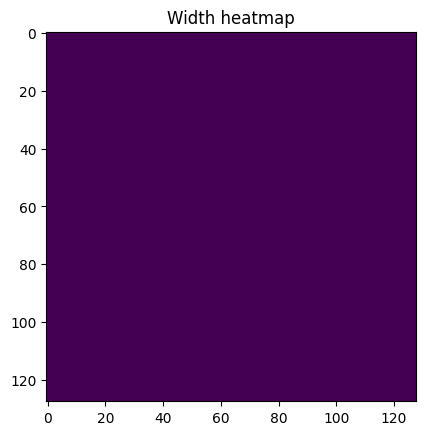

[]
[]


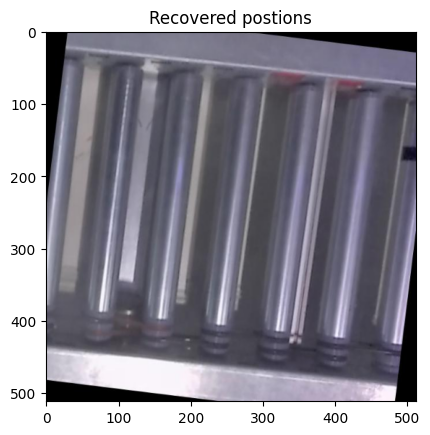

In [26]:
# Check traindataset

k = random.randint(0, len(train_id))
# Test dataset
img, hm, offset, regr,hm_all = traindataset[k]

plt.imshow(hm[0])
plt.title("Main heatmap")
plt.show()

plt.imshow(hm_all)
plt.title("All heatmap")
plt.show()

plt.imshow(offset[0])
plt.title("Offset x heatmap")
plt.show()

plt.imshow(regr[0])
plt.title("Width heatmap")
plt.show()

# plt.imshow(corners[0])
# plt.title("Corner heatmap")
# plt.show()

#print(cos_sin_hm.shape)

# plt.imshow(cos_sin_hm[0])
# plt.title("Cos heatmap")
# plt.show()

# plt.imshow(cos_sin_hm[1])
# plt.title("Sin heatmap")
# plt.show()

# Recover ball detection from heatmaps
img = cv2.imread(train_id[k])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(input_width,input_height))
img = showbox(img, hm[0], offset, regr, 0.99)

plt.imshow(img)
plt.title("Recovered postions")
plt.show()

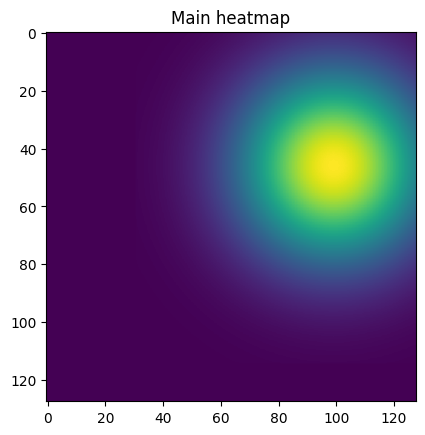

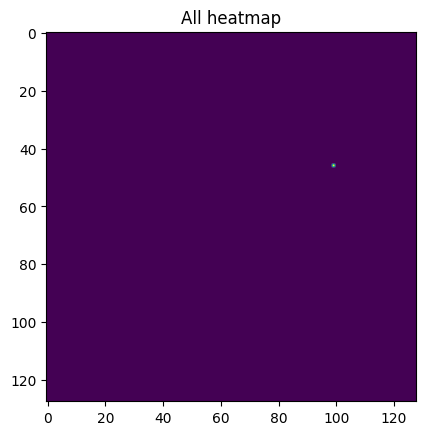

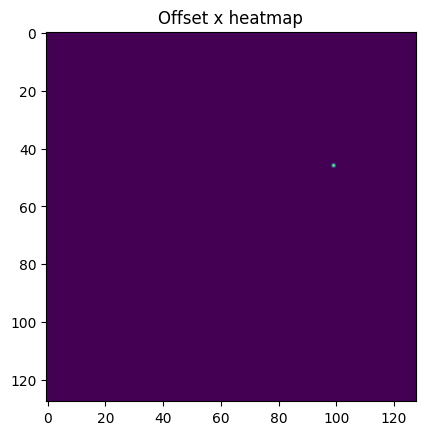

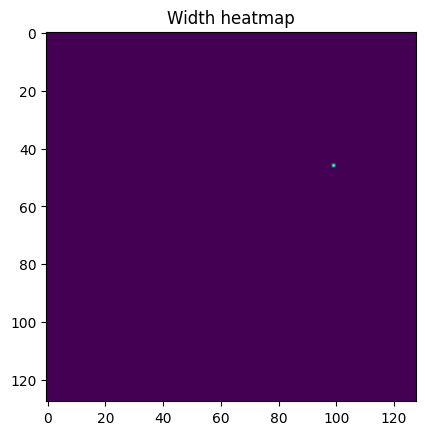

[[ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [57.2 69.4]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]]
[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  57.2  0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  69.4  0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
[392, 172]
[396, 172]
[400, 172]
[388, 176]
[392, 176]
[396, 176]
[400, 176]
[404, 176]
[384, 180]
[388, 180]
[392, 180]
[396, 180]
[400,

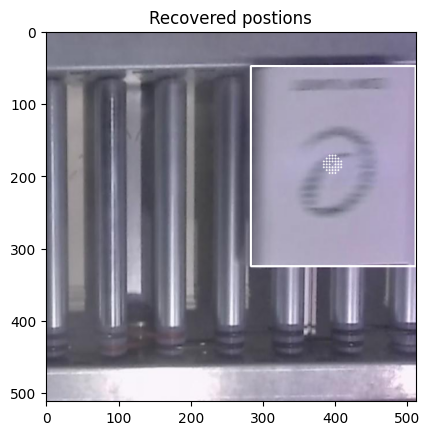

In [27]:
# Check traindataset
k = random.randint(0, len(val_id))
# Test dataset
img, hm, offset, regr,hm_all= valdataset[k]

plt.imshow(hm[0])
plt.title("Main heatmap")
plt.show()

plt.imshow(hm_all)
plt.title("All heatmap")
plt.show()

plt.imshow(offset[0])
plt.title("Offset x heatmap")
plt.show()

plt.imshow(regr[0])
plt.title("Width heatmap")
plt.show()

# plt.imshow(corners[0])
# plt.title("Corner heatmap")
# plt.show()

#print(cos_sin_hm.shape)

# plt.imshow(cos_sin_hm[0])
# plt.title("Cos heatmap")
# plt.show()

# plt.imshow(cos_sin_hm[1])
# plt.title("Sin heatmap")
# plt.show()

# Recover ball detection from heatmaps
img = cv2.imread(val_id[k])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(input_width,input_height))
img = showbox(img, hm[0], offset, regr, 0.99)

plt.imshow(img)
plt.title("Recovered postions")
plt.show()

(512, 512, 3)


/home/rivian/anaconda3/envs/dl/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343962757/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[ 62.4 141.6 450.4 444.8]]


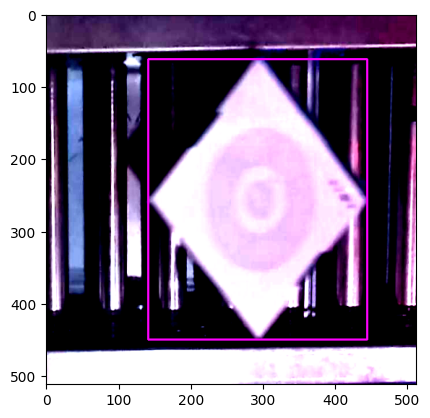

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[ 52.8 135.2 432.8 432. ]]


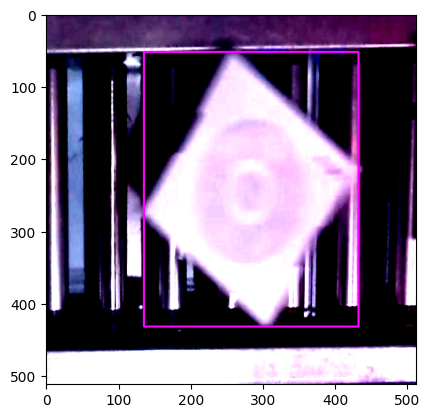

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[107.2 136.8 398.4 360.8]]


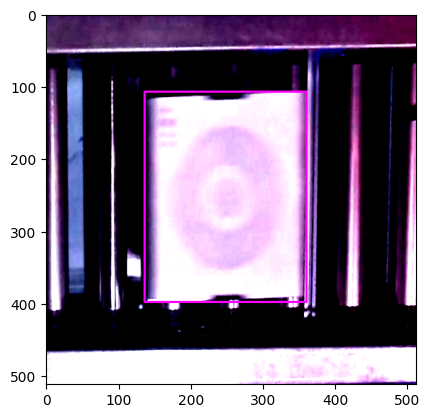

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[ 84.8 201.6 400.8 467.2]]


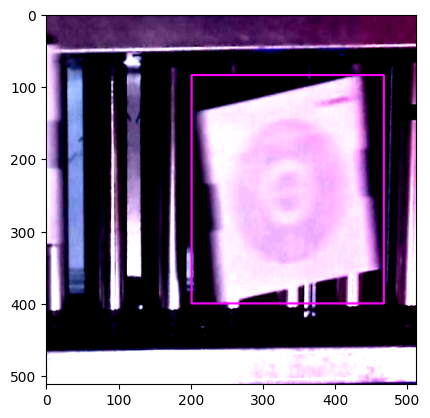

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


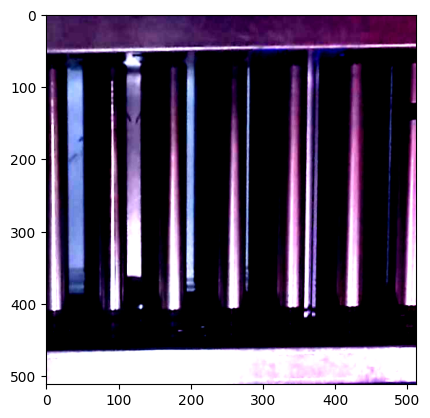

(512, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[ 72.8 352.  451.2 512. ]]


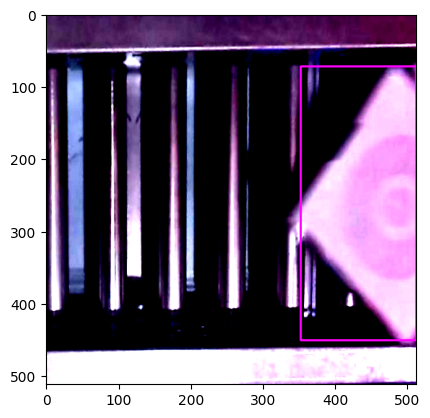

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[ 56.8 256.  443.2 512. ]]


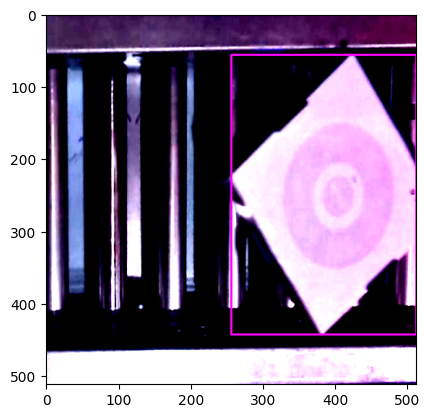

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[ 54.4   0.8 344.8 184.8]]


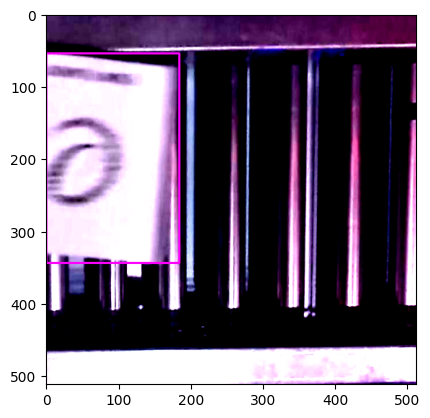

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


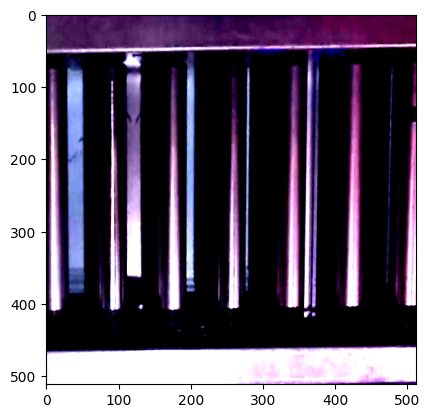

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[ 51.2 209.6 442.4 501.6]]


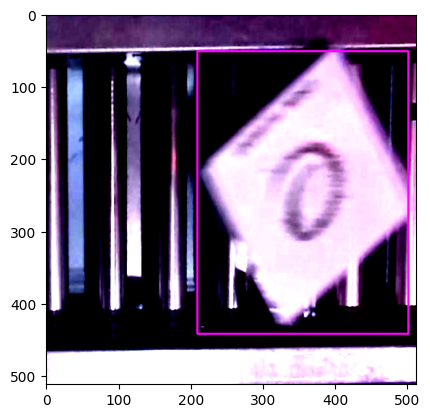

(512, 512, 3)
[[ 39.2 291.2 324.8 512. ]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


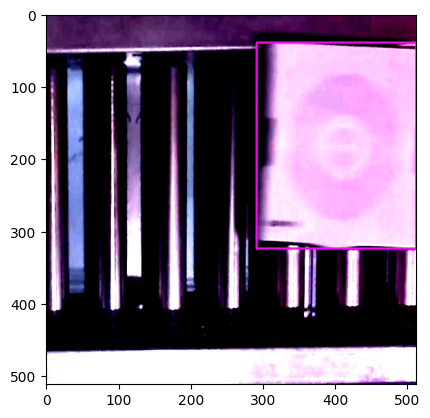

(512, 512, 3)
[[ 48.8 133.6 339.2 380.8]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


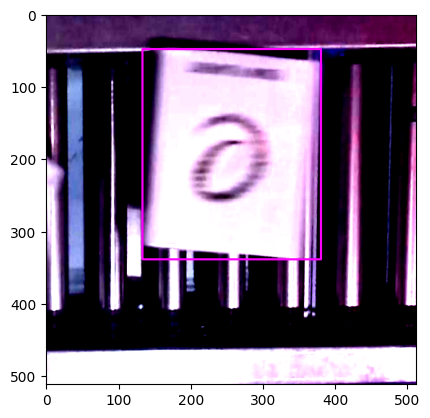

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[ 61.6 357.6 376.8 512. ]]


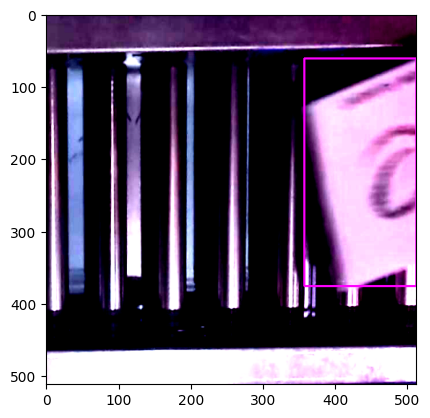

(512, 512, 3)
[[ 44.8   0.8 332.8 160. ]
 [ 50.4 272.  348.8 504. ]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


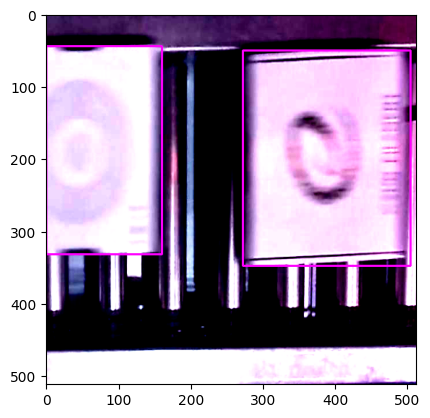

(512, 512, 3)
[[ 56.8 321.6 440.8 512. ]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


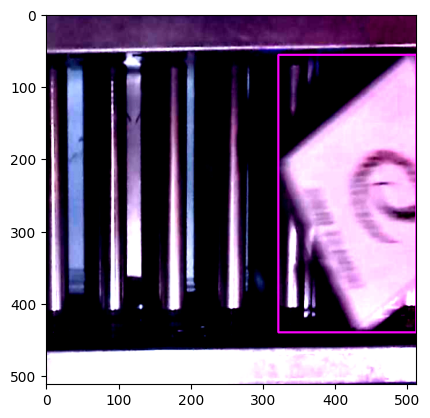

(512, 512, 3)
[[ 40.  439.2 315.2 512. ]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


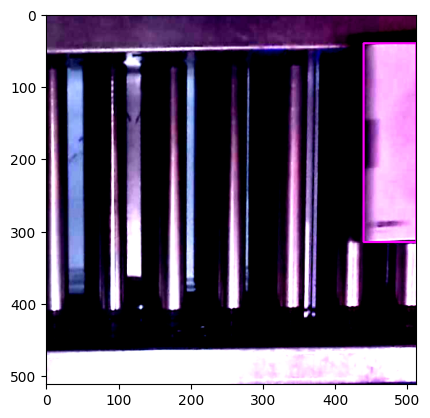

(512, 512, 3)
[[ 48.8 283.2 326.4 512. ]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


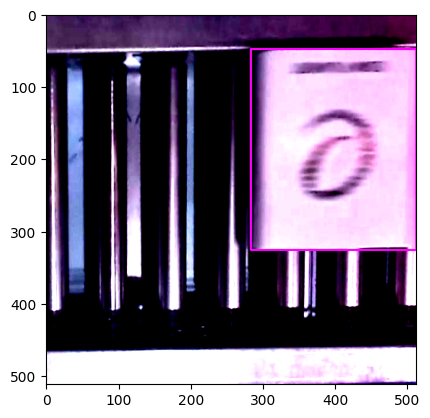

(512, 512, 3)
[[ 46.4 148.  387.2 417.6]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


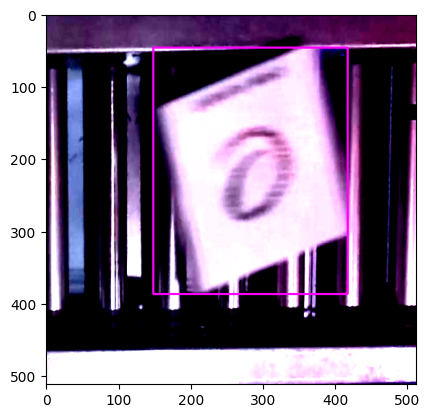

(512, 512, 3)
[[ 63.2   0.8 355.2  88.8]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


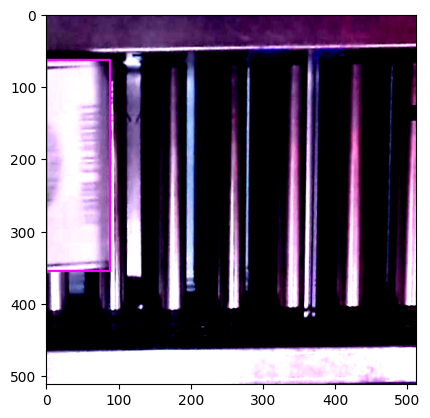

(512, 512, 3)
[[ 46.4   0.8 320.   61.6]
 [ 86.4 248.  398.4 495.2]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


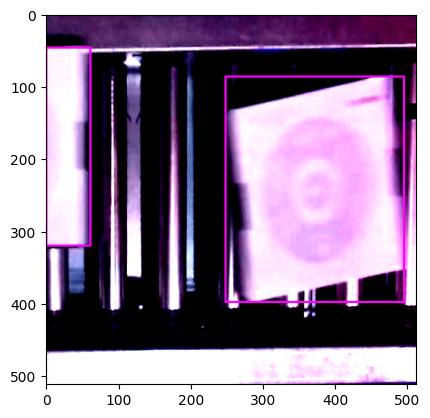

In [28]:
"""
Ground Truth of Validation

"""

for id in range(20):
    img, hm_gt, offset_gt, regr_gt,hm_all = valdataset[id]
    sample = np.transpose(img,(1,2,0)).copy()
    print(sample.shape)
    image_shape = np.array(np.shape(img)[0:2])
    img = torch.from_numpy(img)
    hm = torch.tensor(hm_gt)
    outputs = decode_bbox(hm[None].cuda(),torch.tensor(regr_gt[None]).cuda(),torch.tensor(offset_gt[None]).cuda())
    results = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)
    try:
        top_label   = np.array(results[0][:, 5], dtype = 'int32')
        top_conf    = results[0][:, 4]
        top_boxes   = results[0][:, :4]
        print(top_boxes)
        for box in top_boxes:
            ymin = box[0]
            xmin = box[1] 
            ymax = box[2] 
            xmax = box[3] 
    
            xmin = int(xmin)
            ymin = int(ymin)
            xmax = int(xmax)
            ymax = int(ymax)
    
            cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)
    except:
        pass
    plt.imshow(sample)
    plt.show()

In [29]:
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True,num_workers=8)
val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=False,num_workers=8)

## Define Centernet model

In [30]:
import torch.utils.model_zoo as model_zoo

BN_MOMENTUM = 0.1

model_urls = {'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
              'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
              'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
              'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
              'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth', }


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(
            planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(
            planes * self.expansion, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class PoseResNet(nn.Module):
    def __init__(self, block, layers, head_conv, num_classes):
        super(PoseResNet, self).__init__()
        self.inplanes = 64
        self.deconv_with_bias = False
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # used for deconv layers
        self.deconv_layers = self._make_deconv_layer(
            3, [256, 256, 256], [4, 4, 4])
        # self.final_layer = []

        if head_conv > 0:
            # heatmap layers
            self.hmap = nn.Sequential(nn.Conv2d(256, head_conv, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(head_conv, num_classes, kernel_size=1))
            self.hmap[-1].bias.data.fill_(-2.19)
            # regression layers
            self.regs = nn.Sequential(nn.Conv2d(256, head_conv, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(head_conv, 2, kernel_size=1))
            self.w_h_ = nn.Sequential(nn.Conv2d(256, head_conv, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(head_conv, 2, kernel_size=1))
        else:
            # heatmap layers
            self.hmap = nn.Conv2d(
                in_channels=256, out_channels=num_classes, kernel_size=1)
            # regression layers
            self.regs = nn.Conv2d(
                in_channels=256, out_channels=2, kernel_size=1)
            self.w_h_ = nn.Conv2d(
                in_channels=256, out_channels=2, kernel_size=1)

        # self.final_layer = nn.ModuleList(self.final_layer)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(nn.Conv2d(self.inplanes, planes * block.expansion,
                                                 kernel_size=1, stride=stride, bias=False),
                                       nn.BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM))

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def _get_deconv_cfg(self, deconv_kernel, index):
        if deconv_kernel == 4:
            padding = 1
            output_padding = 0
        elif deconv_kernel == 3:
            padding = 1
            output_padding = 1
        elif deconv_kernel == 2:
            padding = 0
            output_padding = 0

        return deconv_kernel, padding, output_padding

    def _make_deconv_layer(self, num_layers, num_filters, num_kernels):
        assert num_layers == len(num_filters), \
            'ERROR: num_deconv_layers is different len(num_deconv_filters)'
        assert num_layers == len(num_kernels), \
            'ERROR: num_deconv_layers is different len(num_deconv_filters)'

        layers = []
        for i in range(num_layers):
            kernel, padding, output_padding = self._get_deconv_cfg(
                num_kernels[i], i)

            planes = num_filters[i]
            layers.append(nn.ConvTranspose2d(in_channels=self.inplanes,
                                             out_channels=planes,
                                             kernel_size=kernel,
                                             stride=2,
                                             padding=padding,
                                             output_padding=output_padding,
                                             bias=self.deconv_with_bias))
            layers.append(nn.BatchNorm2d(planes, momentum=BN_MOMENTUM))
            layers.append(nn.ReLU(inplace=True))
            self.inplanes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.deconv_layers(x)
        c = self.hmap(x)
        o = self.regs(x) 
        r = self.w_h_(x)
        return c,o,r

    def init_weights(self, num_layers):
        for m in self.deconv_layers.modules():
            if isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, std=0.001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        for m in self.hmap.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.constant_(m.bias, -2.19)
        for m in self.regs.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
                nn.init.constant_(m.bias, 0)
        for m in self.w_h_.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
                nn.init.constant_(m.bias, 0)
        url = model_urls['resnet{}'.format(num_layers)]
        pretrained_state_dict = model_zoo.load_url(url)
        print('=> loading pretrained model {}'.format(url))
        self.load_state_dict(pretrained_state_dict, strict=False)


resnet_spec = {18: (BasicBlock, [2, 2, 2, 2]),
               34: (BasicBlock, [3, 4, 6, 3]),
               50: (Bottleneck, [3, 4, 6, 3]),
               101: (Bottleneck, [3, 4, 23, 3]),
               152: (Bottleneck, [3, 8, 36, 3])}


def resnet_18():
    model = PoseResNet(BasicBlock, [2, 2, 2, 2], head_conv=64, num_classes=len(classes))
    model.init_weights(18)
    return model

def resnet_34():
    model = PoseResNet(BasicBlock, [3, 4, 6, 3], head_conv=64, num_classes=len(classes))
    model.init_weights(34)
    return model


def get_pose_net(num_layers, head_conv, num_classes=80):
    block_class, layers = resnet_spec[num_layers]

    model = PoseResNet(block_class, layers,
                       head_conv=head_conv, num_classes=num_classes)
    model.init_weights(num_layers)
    return model

from nets.resnet50 import resnet50, resnet50_Decoder, resnet50_Head


class CenterNet_Resnet50(nn.Module):
    def __init__(self, num_classes = 20, pretrained = False):
        super(CenterNet_Resnet50, self).__init__()
        self.pretrained = pretrained
        # 512,512,3 -> 16,16,2048
        self.backbone = resnet50(pretrained = pretrained)
        # 16,16,2048 -> 128,128,64
        self.decoder = resnet50_Decoder(2048)
        #-----------------------------------------------------------------#
        #   对获取到的特征进行上采样，进行分类预测和回归预测
        #   128, 128, 64 -> 128, 128, 64 -> 128, 128, num_classes
        #                -> 128, 128, 64 -> 128, 128, 2
        #                -> 128, 128, 64 -> 128, 128, 2
        #-----------------------------------------------------------------#
        self.head = resnet50_Head(channel=64, num_classes=num_classes)
        
        self._init_weights()

    def freeze_backbone(self):
        for param in self.backbone.parameters():
            param.requires_grad = False

    def unfreeze_backbone(self):
        for param in self.backbone.parameters():
            param.requires_grad = True

    def _init_weights(self):
        if not self.pretrained:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                elif isinstance(m, nn.BatchNorm2d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()
        
        self.head.cls_head[-1].weight.data.fill_(0)
        self.head.cls_head[-1].bias.data.fill_(-2.19)
        
    def forward(self, x):
        feat = self.backbone(x)
        return self.head(self.decoder(feat))

# Define Loss (Focal loss + L1-loss)

In [31]:
def focal_loss(pred_mask, gt,gamma=0.2):
    """
    Focal loss was introduced to address the class imbalance problem
    For example here, most of the pixels in the heatmap are negative.
    
    We split the focal loss between positive and negative losses.
    
    https://arxiv.org/pdf/1708.02002.pdf
    
    Code taken from the CenterNet repo.
    """
    gt = gt.unsqueeze(1).float()

    pos_inds = gt.eq(1).float()
    neg_inds = gt.lt(1).float()
    
    neg_weights = torch.pow(1 - gt, 4)

    #with torch.cuda.amp.autocast(enabled=False):
    # add 1e-12 to avoid nan values
    #pos_loss = - torch.pow(1 - pred_mask, gamma) * torch.log(pred_mask + 1e-12) * pos_inds # [2, 1, 128, 128]
    pos_loss = torch.log(pred_mask) * torch.pow(1 - pred_mask, 2) * pos_inds
    neg_loss = torch.log(1 - pred_mask) * torch.pow(pred_mask, 2) * neg_weights * neg_inds
    #neg_loss = - torch.pow(pred_mask, gamma) * torch.log(1 - pred_mask + 1e-12) * neg_inds * neg_weights # [2, 1, 128, 128]
    
    loss = 0
    
    num_pos  = pos_inds.float().sum() # scalar number of positives
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()

    
    # if num_pos == 0:
    #     loss = neg_loss
    # else:
    #     pos_loss /= num_pos
    #     neg_loss /= num_pos
    #     loss = pos_loss + neg_loss

    if num_pos == 0:
        loss = -neg_loss
    else:
        loss = -(pos_loss + neg_loss) / num_pos
        
    assert not torch.isnan(pos_loss)
    assert not torch.isnan(neg_loss)
        
    return loss, pos_loss, neg_loss


def _regr_loss(off_pred, off_gt, wh_pred, wh_gt, hm_all):
    ''' L1 regression loss
    We compute l1 loss over mask of positive pixels for offset, width/height and sine/cosine angle
    '''
    #hm_gt = torch.sum(hm_gt,axis=1)

    mask = hm_all.unsqueeze(1).float()
    
    num = mask.float().sum() 
    #mask_ = mask.expand_as(corner_gt).float()
    mask = mask.expand_as(off_gt).float()
    
    
    assert off_pred.size() == mask.size()
    off_pred = off_pred * mask
    off_gt = off_gt * mask
    wh_pred = wh_pred * mask
    wh_gt = wh_gt * mask
#     corner_pred = corner_pred * mask_
#     corner_gt = corner_gt * mask_
    # angle_pred = angle_pred * mask
    # angle_gt = angle_gt * mask    

    off_loss = nn.functional.l1_loss(off_pred, off_gt, reduction='sum') / (num + 1e-4)
    
    # Scale with 0.1 width and height loss (change it you need)
    wh_loss = 0.1 * nn.functional.l1_loss(wh_pred, wh_gt, reduction='sum') / (num + 1e-4)
    
    #corner_loss =   0.1 * nn.functional.l1_loss(corner_pred, corner_gt, reduction='sum') / (num + 1e-4) 
    
    return off_loss, wh_loss #, corner_loss

def global_loss(hm_pred, hm_gt, off_pred, off_gt, wh_pred, wh_gt,hm_all):
    """
    Global loss is the sum of the focal loss and of the offset loss
        
    Focal loss is the sum of pos_loss and neg_loss, we extract them just for the record
    """
    
    pred_mask = torch.clamp(torch.sigmoid(hm_pred), 1e-6, 1 - 1e-6)
    #print(pred_mask.shape)
    
  
    pred_mask = pred_mask.unsqueeze(1).float()
    #print(pred_mask.shape)
    
    foc_loss, pos_loss, neg_loss = focal_loss(pred_mask, hm_gt)
     
    off_loss, wh_loss = _regr_loss(off_pred, off_gt, wh_pred, wh_gt, hm_all)
    
    assert not torch.isnan(off_loss)
        
    return foc_loss, pos_loss, neg_loss, off_loss, wh_loss

basemodel = timm.create_model('convnext_nano', features_only=True, pretrained=True)

for i in basemodel(torch.rand(1,3,1280,720)): 
    print(i.shape)
    print(i.size(2))

# Training

In [32]:
"""
hm = torch.tensor(hm_gt)
outputs = decode_bbox(hm[None].cuda(),torch.tensor(regr_gt[None]).cuda(),torch.tensor(offset_gt[None]).cuda())
results = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)
top_label   = np.array(results[0][:, 5], dtype = 'int32')
top_conf    = results[0][:, 4]
top_boxes   = results[0][:, :4]
print(top_boxes)
for box in top_boxes:
    ymin = box[0]
    xmin = box[1] 
    ymax = box[2] 
    xmax = box[3] 

    xmin = int(xmin)
    ymin = int(ymin)
    xmax = int(xmax)
    ymax = int(ymax)

    cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)



"""

"\nhm = torch.tensor(hm_gt)\noutputs = decode_bbox(hm[None].cuda(),torch.tensor(regr_gt[None]).cuda(),torch.tensor(offset_gt[None]).cuda())\nresults = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)\ntop_label   = np.array(results[0][:, 5], dtype = 'int32')\ntop_conf    = results[0][:, 4]\ntop_boxes   = results[0][:, :4]\nprint(top_boxes)\nfor box in top_boxes:\n    ymin = box[0]\n    xmin = box[1] \n    ymax = box[2] \n    xmax = box[3] \n\n    xmin = int(xmin)\n    ymin = int(ymin)\n    xmax = int(xmax)\n    ymax = int(ymax)\n\n    cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)\n\n\n\n"

In [33]:
def pool_nms(heat, kernel = 3):
    pad = (kernel - 1) // 2

    hmax = nn.functional.max_pool2d(heat, (kernel, kernel), stride=1, padding=pad)
    keep = (hmax == heat).float()
    return heat * keep




def decode_bbox(pred_hms, pred_whs, pred_offsets, confidence=0.3, cuda=True):
    #-------------------------------------------------------------------------#
    #   当利用512x512x3图片进行coco数据集预测的时候
    #   h = w = 128 num_classes = 80
    #   Hot map热力图 -> b, 80, 128, 128, 
    #   进行热力图的非极大抑制，利用3x3的卷积对热力图进行最大值筛选
    #   找出一定区域内，得分最大的特征点。
    #-------------------------------------------------------------------------#
    pred_hms = pool_nms(pred_hms)
    
    b, c, output_h, output_w = pred_hms.shape
    detects = []
    #-------------------------------------------------------------------------#
    #   只传入一张图片，循环只进行一次
    #-------------------------------------------------------------------------#
    for batch in range(b):
        #-------------------------------------------------------------------------#
        #   heat_map        128*128, num_classes    热力图
        #   pred_wh         128*128, 2              特征点的预测宽高
        #                                           在预测过程的前处理以及后处理视频中讲的有点小问题，不是调整参数，就是宽高
        #   pred_offset     128*128, 2              特征点的xy轴偏移情况
        #-------------------------------------------------------------------------#
        heat_map    = pred_hms[batch].permute(1, 2, 0).view([-1, c])
        pred_wh     = pred_whs[batch].permute(1, 2, 0).view([-1, 2])
        pred_offset = pred_offsets[batch].permute(1, 2, 0).view([-1, 2])

        yv, xv      = torch.meshgrid(torch.arange(0, output_h), torch.arange(0, output_w))
        #-------------------------------------------------------------------------#
        #   xv              128*128,    特征点的x轴坐标
        #   yv              128*128,    特征点的y轴坐标
        #-------------------------------------------------------------------------#
        xv, yv      = xv.flatten().float(), yv.flatten().float()
        if cuda:
            xv      = xv.cuda()
            yv      = yv.cuda()

        #-------------------------------------------------------------------------#
        #   class_conf      128*128,    特征点的种类置信度
        #   class_pred      128*128,    特征点的种类
        #-------------------------------------------------------------------------#
        class_conf, class_pred  = torch.max(heat_map, dim = -1)
        mask                    = class_conf > confidence

        #-----------------------------------------#
        #   取出得分筛选后对应的结果
        #-----------------------------------------#
        pred_wh_mask        = pred_wh[mask]
        pred_offset_mask    = pred_offset[mask]
        if len(pred_wh_mask) == 0:
            detects.append([])
            continue     

        #----------------------------------------#
        #   计算调整后预测框的中心
        #----------------------------------------#
        xv_mask = torch.unsqueeze(xv[mask] + pred_offset_mask[..., 0], -1)
        yv_mask = torch.unsqueeze(yv[mask] + pred_offset_mask[..., 1], -1)
        #----------------------------------------#
        #   计算预测框的宽高
        #----------------------------------------#
        half_w, half_h = pred_wh_mask[..., 0:1] / 2, pred_wh_mask[..., 1:2] / 2
        #----------------------------------------#
        #   获得预测框的左上角和右下角
        #----------------------------------------#
        bboxes = torch.cat([xv_mask - half_w, yv_mask - half_h, xv_mask + half_w, yv_mask + half_h], dim=1)
        bboxes[:, [0, 2]] /= output_w
        bboxes[:, [1, 3]] /= output_h
        detect = torch.cat([bboxes, torch.unsqueeze(class_conf[mask],-1), torch.unsqueeze(class_pred[mask],-1).float()], dim=-1)
        detects.append(detect)

    return detects

def centernet_correct_boxes(box_xy, box_wh, input_shape, image_shape, letterbox_image):
    #-----------------------------------------------------------------#
    #   把y轴放前面是因为方便预测框和图像的宽高进行相乘
    #-----------------------------------------------------------------#
    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]
    input_shape = np.array(input_shape)
    image_shape = np.array(image_shape)

    if letterbox_image:
        #-----------------------------------------------------------------#
        #   这里求出来的offset是图像有效区域相对于图像左上角的偏移情况
        #   new_shape指的是宽高缩放情况
        #-----------------------------------------------------------------#
        new_shape = np.round(image_shape * np.min(input_shape/image_shape))
        offset  = (input_shape - new_shape)/2./input_shape
        scale   = input_shape/new_shape

        box_yx  = (box_yx - offset) * scale
        box_hw *= scale

    box_mins    = box_yx - (box_hw / 2.)
    box_maxes   = box_yx + (box_hw / 2.)
    boxes  = np.concatenate([box_mins[..., 0:1], box_mins[..., 1:2], box_maxes[..., 0:1], box_maxes[..., 1:2]], axis=-1)
    boxes *= np.concatenate([image_shape, image_shape], axis=-1)
    return boxes

def postprocess(prediction, need_nms, image_shape, input_shape, letterbox_image, nms_thres=0.4):
    output = [None for _ in range(len(prediction))]
    
    #----------------------------------------------------------#
    #   预测只用一张图片，只会进行一次
    #----------------------------------------------------------#
    for i, image_pred in enumerate(prediction):
        detections      = prediction[i]
        if len(detections) == 0:
            continue
        #------------------------------------------#
        #   获得预测结果中包含的所有种类
        #------------------------------------------#
        unique_labels   = detections[:, -1].cpu().unique()

        if detections.is_cuda:
            unique_labels = unique_labels.cuda()
            detections = detections.cuda()

        for c in unique_labels:
            #------------------------------------------#
            #   获得某一类得分筛选后全部的预测结果
            #------------------------------------------#
            detections_class = detections[detections[:, -1] == c]
            if need_nms:
                #------------------------------------------#
                #   使用官方自带的非极大抑制会速度更快一些！
                #------------------------------------------#
                keep = nms(
                    detections_class[:, :4],
                    detections_class[:, 4],
                    nms_thres
                )
                max_detections = detections_class[keep]

                # #------------------------------------------#
                # #   按照存在物体的置信度排序
                # #------------------------------------------#
                # _, conf_sort_index = torch.sort(detections_class[:, 4], descending=True)
                # detections_class = detections_class[conf_sort_index]
                # #------------------------------------------#
                # #   进行非极大抑制
                # #------------------------------------------#
                # max_detections = []
                # while detections_class.size(0):
                #     #---------------------------------------------------#
                #     #   取出这一类置信度最高的，一步一步往下判断。
                #     #   判断重合程度是否大于nms_thres，如果是则去除掉
                #     #---------------------------------------------------#
                #     max_detections.append(detections_class[0].unsqueeze(0))
                #     if len(detections_class) == 1:
                #         break
                #     ious = bbox_iou(max_detections[-1], detections_class[1:])
                #     detections_class = detections_class[1:][ious < nms_thres]
                # #------------------------------------------#
                # #   堆叠
                # #------------------------------------------#
                # max_detections = torch.cat(max_detections).data
            else:
                max_detections  = detections_class
            
            output[i] = max_detections if output[i] is None else torch.cat((output[i], max_detections))

        if output[i] is not None:
            output[i]           = output[i].cpu().numpy()
            box_xy, box_wh      = (output[i][:, 0:2] + output[i][:, 2:4])/2, output[i][:, 2:4] - output[i][:, 0:2]
            output[i][:, :4]    = centernet_correct_boxes(box_xy, box_wh, input_shape, image_shape, letterbox_image)
    return output

t = tqdm(train_loader)
device = "cuda"
for idx, (img, hm, offset, regr,hm_all) in enumerate(t):       
        # send to gpu
        img = img.to(device)
        hm_gt = hm.to(device)
        offset_gt = offset.to(device)
        wh_gt = regr.to(device)
        hm_all = hm_all.to(device)
        image_shape = [512,512]
        for t in range(len(img)):
            sample = img[t].cpu().permute(1,2,0).numpy().copy()
            hm = torch.tensor(hm_gt[t])
            #hm = torch.sigmoid(hm)
            outputs = decode_bbox(hm[None].cuda(),torch.tensor(wh_gt[t][None]).cuda(),torch.tensor(offset_gt[t][None]).cuda())
            results = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)
            top_label   = np.array(results[0][:, 5], dtype = 'int32')
            top_conf    = results[0][:, 4]
            top_boxes   = results[0][:, :4]
            #print(top_boxes)
            for box in top_boxes:
                ymin = box[0]
                xmin = box[1] 
                ymax = box[2] 
                xmax = box[3] 

                xmin = int(xmin)
                ymin = int(ymin)
                xmax = int(xmax)
                ymax = int(ymax)
                #print(xmin,ymin,xmax,ymax)
                cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)
            plt.imshow(sample)
            plt.show()
            #break

In [34]:
from mean_average_precision import MetricBuilder

In [35]:
"""
# [xmin, ymin, xmax, ymax, class_id, difficult, crowd]
gt = np.array([
    [439, 157, 556, 241, 0, 0, 0],
    [437, 246, 518, 351, 0, 0, 0],
    [515, 306, 595, 375, 0, 0, 0],
    [407, 386, 531, 476, 0, 0, 0],
    [544, 419, 621, 476, 0, 0, 0],
    [609, 297, 636, 392, 0, 0, 0]
])

# [xmin, ymin, xmax, ymax, class_id, confidence]
preds = np.array([
    [429, 219, 528, 247, 0, 0.460851],
    [433, 260, 506, 336, 0, 0.269833],
    [518, 314, 603, 369, 0, 0.462608],
    [592, 310, 634, 388, 0, 0.298196],
    [403, 384, 517, 461, 0, 0.382881],
    [405, 429, 519, 470, 0, 0.369369],
    [433, 272, 499, 341, 0, 0.272826],
    [413, 390, 515, 459, 0, 0.619459]
])


"""

'\n# [xmin, ymin, xmax, ymax, class_id, difficult, crowd]\ngt = np.array([\n    [439, 157, 556, 241, 0, 0, 0],\n    [437, 246, 518, 351, 0, 0, 0],\n    [515, 306, 595, 375, 0, 0, 0],\n    [407, 386, 531, 476, 0, 0, 0],\n    [544, 419, 621, 476, 0, 0, 0],\n    [609, 297, 636, 392, 0, 0, 0]\n])\n\n# [xmin, ymin, xmax, ymax, class_id, confidence]\npreds = np.array([\n    [429, 219, 528, 247, 0, 0.460851],\n    [433, 260, 506, 336, 0, 0.269833],\n    [518, 314, 603, 369, 0, 0.462608],\n    [592, 310, 634, 388, 0, 0.298196],\n    [403, 384, 517, 461, 0, 0.382881],\n    [405, 429, 519, 470, 0, 0.369369],\n    [433, 272, 499, 341, 0, 0.272826],\n    [413, 390, 515, 459, 0, 0.619459]\n])\n\n\n'

In [36]:
classes

['BOX']

In [37]:
metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=len(classes))

In [38]:
skipped_updates = 0

In [39]:
def train(epoch):
    print(f'epochs {epoch+1}/{epochs}')
    print(f'Learning rate : {optimizer.param_groups[0]["lr"]}')
    train_loss = 0.0
    train_pos_loss = 0.0
    train_neg_loss = 0.0
    train_off_loss = 0.0
    train_wh_loss = 0.0
    #train_corner_loss = 0.0
    #train_angle_loss = 0.0
    t = tqdm(train_loader)
    rd = np.random.rand()
    
    # Training
    model.train()
    for idx, (img, hm, offset, regr,hm_all) in enumerate(t):       
        set_optimizer_lr(optimizer, lr_scheduler_func, epoch)
        # send to gpu
        img = img.to(device)
        hm_gt = hm.to(device)
        offset_gt = offset.to(device)
        wh_gt = regr.to(device)
        hm_all = hm_all.to(device)
        #corner_gt = corner.to(device)
        #angle_gt = angle.to(device)
        # set opt
        optimizer.zero_grad()

        #n_iteration = (iterations_per_epoch * epoch) + idx
        #print("N_iteration:" ,n_iteration)
        # run model
        #with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
        #with torch.cuda.amp.autocast(enabled=True):
        preds_hm, preds_offset, preds_wh = model(img)
        assert not np.isnan(preds_hm.cpu().detach().numpy()[0, 0, 0, 0])

        foc_loss, pos_loss, neg_loss, off_loss, wh_loss = global_loss(preds_hm, hm_gt, preds_offset, offset_gt, preds_wh, wh_gt,hm_all)
            
        loss = foc_loss + off_loss + wh_loss 
        #loss = loss / batch_size

        if torch.isnan(loss):
            print("NAN loss")
            continue
            
        # misc
        train_loss += float(loss) # TRICK to avoid GPU memory increasing
        train_pos_loss += float(pos_loss)
        train_neg_loss += float(neg_loss)
        train_off_loss += float(off_loss)
        train_wh_loss += float(wh_loss)
        #train_corner_loss += float(corner_loss)
        if (use_amp == False):
            loss.backward()
            # NB: I tried to use gradient clipping to avoid NaN values but it didnt work as expected
            optimizer.step()

        if (use_amp):
        
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)

        total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)  # grad clip helps in both amp and fp32
        # if torch.logical_or(total_norm.isnan(), total_norm.isinf()): 
        #     # scaler is going to skip optimizer.step() if grads are nan or inf
        #     # some updates are skipped anyway in the amp mode, but we can count for statistics
        #     skipped_updates += 1  

        if (use_amp):
        
            scaler.step(optimizer)
            scaler.update()
    
            if scaler._scale < min_scale:
                scaler._scale = torch.tensor(min_scale).to(scaler._scale)
            
        #optimizer.zero_grad()
        # scaler.step(optimizer)
        # scaler.update()
        # optimizer.zero_grad() # set_to_none=True here can modestly improve performance

        # if (n_iteration + 1) % iters_to_accumulate == 0:
        #     scaler.step(optimizer)
        #     scaler.update()
        #     optimizer.zero_grad()



        # if n_iteration > warmup_iteration:
        #     scheduler.step()
        # else:
        #     lr = initial_lr * float(n_iteration) / warmup_iteration
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] = lr

        # if scaler._scale < 128: #min_scale = 128 #https://github.com/pytorch/pytorch/issues/40497#issuecomment-1671378473
        #     scaler._scale = torch.tensor(128).to(scaler._scale)


        
        
        t.set_description(f'(l={train_loss/(idx+1):.2f}) (off={train_off_loss/(idx+1):.3f}) (wh={train_wh_loss/(idx+1):.3f})')
    
    # Validation
    val_loss = 0.0
    val_pos_loss = 0.0
    val_neg_loss = 0.0
    val_off_loss = 0.0
    val_wh_loss = 0.0
    #val_corner_loss = 0.0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (img, hm, offset, regr,hm_all) in enumerate(tqdm(val_loader)):       
            # send to gpu
            img = img.to(device)
            hm_gt = hm.to(device)
            offset_gt = offset.to(device)
            wh_gt = regr.to(device)
            hm_all = hm_all.to(device)
            #corner_gt = corner.to(device)
            #angle_gt = angle.to(device)

            # run model
            #with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            preds_hm, preds_offset, preds_wh = model(img)

            foc_loss, pos_loss, neg_loss, off_loss, wh_loss = global_loss(preds_hm, hm_gt, preds_offset, offset_gt, preds_wh, wh_gt,hm_all)

            loss = foc_loss + off_loss + wh_loss 
            #loss = loss / batch_size
            
#             """gt"""
#             gts = []
#             image_shape = [512,512]
#             for t in range(len(img)):
#                 sample = img[t].cpu().permute(1,2,0).numpy().copy()
#                 hm = hm_gt[t]
#                 outputs = decode_bbox(hm[None].cuda(),wh_gt[t][None].cuda(),offset_gt[t][None].cuda(),confidence=0.05)
#                 results = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)
#                 if results is not None and len(results) > 0:
#                     try:
#                         top_label   = np.array(results[0][:, 5], dtype = 'int32')
#                         top_conf    = results[0][:, 4]
#                         top_boxes   = results[0][:, :4]

#                         for (conf,label,box) in zip(top_conf,top_label,top_boxes):
#                             ymin = box[0]
#                             xmin = box[1] 
#                             ymax = box[2] 
#                             xmax = box[3] 

#                             xmin = int(xmin)
#                             ymin = int(ymin)
#                             xmax = int(xmax)
#                             ymax = int(ymax)
#                             class_label = label

#                             cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)
#                             cv2.putText(img = sample,text = f"{classes[class_label]}",org = (xmin,ymin-5),
#                             fontFace = cv2.FONT_HERSHEY_DUPLEX,fontScale = 0.8,color = (255, 255, 255),
#                             thickness = 1
#                             )
#                             cv2.putText(img = sample,text = f"{conf:2f}",org = (xmax,ymin-5),
#                             fontFace = cv2.FONT_HERSHEY_DUPLEX,fontScale = 0.8,color = (255, 255, 255),
#                             thickness = 1
#                             )
#                             row = [xmin, ymin, xmax, ymax, label, 0, 0]
#                             gts.append(row)
#                     except:
#                         pass
                
                    
                    
                    
#                 #plt.title("gt")
#                 #plt.imshow(sample)
#                 #plt.show()
                
#             """pred"""
            
#             preds = []
#             for t in range(len(img)):
#                 sample = img[t].cpu().permute(1,2,0).numpy().copy()
#                 hm = preds_hm[t]
#                 hm = torch.sigmoid(hm)
#                 outputs = decode_bbox(hm[None].cuda(),preds_wh[t][None].cuda(),preds_offset[t][None].cuda(),confidence=0.05)
#                 results = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)
#                 if results is not None and len(results) > 0:
#                     try:
#                         top_label   = np.array(results[0][:, 5], dtype = 'int32')
#                         top_conf    = results[0][:, 4]
#                         top_boxes   = results[0][:, :4]

#                         for (conf,label,box) in zip(top_conf,top_label,top_boxes):
#                             ymin = box[0]
#                             xmin = box[1] 
#                             ymax = box[2] 
#                             xmax = box[3] 

#                             xmin = int(xmin)
#                             ymin = int(ymin)
#                             xmax = int(xmax)
#                             ymax = int(ymax)
#                             class_label = label

#                             cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)
#                             cv2.putText(img = sample,text = f"{classes[class_label]}",org = (xmin,ymin-5),
#                             fontFace = cv2.FONT_HERSHEY_DUPLEX,fontScale = 0.8,color = (255, 255, 255),
#                             thickness = 1
#                             )
#                             cv2.putText(img = sample,text = f"{conf:2f}",org = (xmax,ymin-5),
#                             fontFace = cv2.FONT_HERSHEY_DUPLEX,fontScale = 0.8,color = (255, 255, 255),
#                             thickness = 1
#                             )

#                             row = [xmin, ymin, xmax, ymax,label,conf]
#                             preds.append(row)
#                     except:
#                         pass
                    
                    
# #                 plt.title("pred")
# #                 plt.imshow(sample)
                
# #                 plt.show()
                
#             preds = np.array(preds)
#             gts = np.array(gts)
#             metric_fn.add(preds, gts)
                
            
            
            
            
            
            
            
            
            
            
            # misc
            val_loss += float(loss)
            val_pos_loss += float(pos_loss)
            val_neg_loss += float(neg_loss)
            val_off_loss += float(off_loss)
            val_wh_loss += float(wh_loss)
            #val_corner_loss += float(corner_loss)
            
    #mAP = metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP'] #metric_fn.value(iou_thresholds=0.5)['mAP']
    # mAP = metric_fn.value(iou_thresholds=0.5)['mAP']
            
    # print(f"Pascal VOC mAP in all points: {mAP}")

    # if (epoch) % 1 == 0:
    #     calc_det(model)
    #     f = !python /home/rivian/Desktop/mAP/main.py --no-animation
    #     mAP_general = float(f[-2].split('=')[-1].split('%')[0].split()[0])
    #     print("GENERAL MAP:",mAP_general)
    calc_det(model)
    cocoDt = cocoGt.loadRes("detection_results.json")
    cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

    print(f'train loss : {train_loss/len(train_loader):.4f}')
    print(f'Pos loss : {train_pos_loss/len(train_loader):.4f}')
    print(f'Neg loss : {train_neg_loss/len(train_loader):.4f}')
    print(f'Off loss : {train_off_loss/len(train_loader):.4f}')
    print(f'Wh loss : {train_wh_loss/len(train_loader):.4f}')
    #print(f'Corner loss : {train_corner_loss/len(train_loader):.4f}')
    
    print("")
    print(f'Val loss : {val_loss/len(val_loader):.4f}')
    print(f'Val Pos loss : {val_pos_loss/len(val_loader):.4f}')
    print(f'Val Neg loss : {val_neg_loss/len(val_loader):.4f}')
    print(f'Val Off loss : {val_off_loss/len(val_loader):.4f}')
    print(f'Val Wh loss : {val_wh_loss/len(val_loader):.4f}')
    #print(f'Val Corner loss : {val_corner_loss/len(val_loader):.4f}')
    
    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                'train_loss': train_loss/len(train_loader), 'train_pos_loss': train_pos_loss/len(train_loader),
                'train_neg_loss': train_neg_loss/len(train_loader), 'train_off_loss': train_off_loss/len(train_loader), 
                'val_loss': val_loss/len(val_loader), 'val_pos_loss': val_pos_loss/len(val_loader),
                'val_neg_loss': val_neg_loss/len(val_loader), 'val_off_loss': val_off_loss/len(val_loader)
                 }
    logs.append(log_epoch)
    
    return val_loss/len(val_loader)

cocoDt = cocoGt.loadRes("detection_results.json")

# Check the number of images and annotations
print(f"Number of images in ground truth: {len(cocoGt.imgs)}")
print(f"Number of annotations in ground truth: {len(cocoGt.anns)}")
print(f"Number of detections: {len(cocoDt.anns)}")

# Display a few examples
print("Some ground truth annotations:")
for ann_id, ann in list(cocoGt.anns.items())[:5]:
    print(ann)

print("Some detection results:")
for ann_id, ann in list(cocoDt.anns.items())[:5]:
    print(ann)

In [40]:
def get_lr_scheduler(lr_decay_type, lr, min_lr, total_iters, warmup_iters_ratio = 0.05, warmup_lr_ratio = 0.1, no_aug_iter_ratio = 0.05, step_num = 10):
    def yolox_warm_cos_lr(lr, min_lr, total_iters, warmup_total_iters, warmup_lr_start, no_aug_iter, iters):
        if iters <= warmup_total_iters:
            # lr = (lr - warmup_lr_start) * iters / float(warmup_total_iters) + warmup_lr_start
            lr = (lr - warmup_lr_start) * pow(iters / float(warmup_total_iters), 2) + warmup_lr_start
        elif iters >= total_iters - no_aug_iter:
            lr = min_lr
        else:
            lr = min_lr + 0.5 * (lr - min_lr) * (
                1.0 + math.cos(math.pi* (iters - warmup_total_iters) / (total_iters - warmup_total_iters - no_aug_iter))
            )
        return lr

    def step_lr(lr, decay_rate, step_size, iters):
        if step_size < 1:
            raise ValueError("step_size must above 1.")
        n       = iters // step_size
        out_lr  = lr * decay_rate ** n
        return out_lr

    if lr_decay_type == "cos":
        warmup_total_iters  = min(max(warmup_iters_ratio * total_iters, 1), 3)
        warmup_lr_start     = max(warmup_lr_ratio * lr, 1e-6)
        no_aug_iter         = min(max(no_aug_iter_ratio * total_iters, 1), 15)
        func = partial(yolox_warm_cos_lr ,lr, min_lr, total_iters, warmup_total_iters, warmup_lr_start, no_aug_iter)
    else:
        decay_rate  = (min_lr / lr) ** (1 / (step_num - 1))
        step_size   = total_iters / step_num
        func = partial(step_lr, lr, decay_rate, step_size)

    return func

def set_optimizer_lr(optimizer, lr_scheduler_func, epoch):
    lr = lr_scheduler_func(epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [41]:
#model = CenterNet_Resnet50(len(classes), pretrained = True)
model = resnet_18()
#model = resnet_34()
#model = CenterNet_Resnet50(len(classes), pretrained = True)
name = "resnet18"
#model.load_state_dict(torch.load("centernet-oriented-bbox.pth"))
#model.load_state_dict(torch.load(f"rn50-{name}.pth"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.01,weight_decay=0.0001)
epochs = 100 #15 * 6 * 2 
#optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)

optimizer_type = "adam"
momentum            = 0.9
weight_decay        = 0
nbs             = 64
Init_lr             = 5e-4
Min_lr              = Init_lr * 0.01
lr_limit_max    = 5e-4 if optimizer_type == 'adam' else 5e-2
lr_limit_min    = 2.5e-4 if optimizer_type == 'adam' else 5e-4
Init_lr_fit     = min(max(batch_size / nbs * Init_lr, lr_limit_min), lr_limit_max)
Min_lr_fit      = min(max(batch_size / nbs * Min_lr, lr_limit_min * 1e-2), lr_limit_max * 1e-2)
lr_decay_type       = 'cos'
optimizer = optim.Adam(model.parameters(), Init_lr_fit, betas = (momentum, 0.999), weight_decay = weight_decay)


lr_scheduler_func = get_lr_scheduler(lr_decay_type, Init_lr_fit, Min_lr_fit, epochs) 
#----------------------------------------
# iters_to_accumulate = max(round(32/32), 1)
# initial_lr = 5e-4 * (32/128)

# for param_group in optimizer.param_groups:
#     param_group['lr'] = 0.

# iterations_per_epoch = len(train_loader)
# total_iteration =  iterations_per_epoch * epochs
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_iteration)

# warmup_iteration = 1000
#----------------------------------------

scaler = torch.cuda.amp.GradScaler(growth_interval=100)
min_scale = 128
logs = []
best_loss = float('inf')
best_mean_AP = 0

=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth


In [42]:
img, hm, offset, regr,hm_all = next(iter(train_loader))

In [43]:
#import thop
# flops, params   = thop.profile(model, (img.cuda(),), verbose=False)
# flops = flops * 2
# flops, params   = thop.clever_format([flops, params], "%.3f")
# print('Total GFLOPS: %s' % (flops))
# print('Total params: %s' % (params))

In [44]:
hm.shape 

torch.Size([4, 1, 128, 128])

In [45]:
img.shape

torch.Size([4, 3, 512, 512])

In [46]:
use_amp = False
device = 'cuda'
for epoch in range(epochs):
    val_loss = train(epoch)
    torch.save(model.state_dict(), f"rn-{name}_last.pth")  
    #scheduler.step(val_loss)
    # if val_loss < best_loss:
    #     best_loss = val_loss
    #     print(f"Improved validation loss to {best_loss:.3f}")
    #     #torch.save(model.state_dict(), f"centernet-xml-{name}.pth")   
    # if mean_AP > best_mean_AP:
    #     best_mean_AP = mean_AP
    #     print(f"Improved validation mAP to {best_mean_AP:.3f}")
    #     torch.save(model.state_dict(), f"rn-{name}.pth")

epochs 1/100
Learning rate : 0.00025


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  4.00it/s]


Loading and preparing results...
DONE (t=0.98s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.31s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=

100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.72it/s]


Loading and preparing results...
DONE (t=0.29s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=

100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.63it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.096
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.096
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=

100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.87it/s]


Could not infer an error occured: 'NoneType' object is not subscriptable
Could not infer an error occured: 'NoneType' object is not subscriptable
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.881
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.338


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.26it/s]


Could not infer an error occured: 'NoneType' object is not subscriptable
Could not infer an error occured: 'NoneType' object is not subscriptable
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.572
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.881
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.658
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.572
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.581
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.600


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.78it/s]


Could not infer an error occured: 'NoneType' object is not subscriptable
Could not infer an error occured: 'NoneType' object is not subscriptable
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.535
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.881
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.535
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.546
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.562


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.54it/s]


Could not infer an error occured: 'NoneType' object is not subscriptable
Could not infer an error occured: 'NoneType' object is not subscriptable
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.598
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.881
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.706
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.598
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.604
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.623


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.75it/s]


Could not infer an error occured: 'NoneType' object is not subscriptable
Could not infer an error occured: 'NoneType' object is not subscriptable
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.587
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.881
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.701
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.587
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.604
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.623


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.83it/s]


Could not infer an error occured: 'NoneType' object is not subscriptable
Could not infer an error occured: 'NoneType' object is not subscriptable
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.619
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.881
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.694
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.619
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.631
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.646


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.69it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.460
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.881
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.465
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.460
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.515
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.46it/s]


Could not infer an error occured: 'NoneType' object is not subscriptable
Could not infer an error occured: 'NoneType' object is not subscriptable
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.592
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.881
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.666
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.592
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.627
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.642


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.58it/s]


Could not infer an error occured: 'NoneType' object is not subscriptable
Could not infer an error occured: 'NoneType' object is not subscriptable
Could not infer an error occured: 'NoneType' object is not subscriptable
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.536
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.878
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.485
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.536
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.538
 Averag

100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.83it/s]


Could not infer an error occured: 'NoneType' object is not subscriptable
Could not infer an error occured: 'NoneType' object is not subscriptable
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.556
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.878
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.619
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.556
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.604
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.619


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.77it/s]


Could not infer an error occured: 'NoneType' object is not subscriptable
Could not infer an error occured: 'NoneType' object is not subscriptable
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.581
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.881
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.691
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.581
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.615


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.54it/s]


Could not infer an error occured: 'NoneType' object is not subscriptable
Could not infer an error occured: 'NoneType' object is not subscriptable
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.590
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.881
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.661
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.590
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.619
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.638


(l=2.03) (off=0.479) (wh=1.387):   6%|▌          | 5/90 [00:04<01:16,  1.12it/s]


KeyboardInterrupt: 

In [ ]:
#torch.save(model.state_dict(), f"centernet-barcode-{name}_last.pth")   

In [ ]:
bitiş

In [ ]:
loss_iter = [log["train_loss"] for log in logs]
val_loss_iter = [log["val_loss"] for log in logs]
plt.plot(loss_iter[1:], label="Train")
plt.plot(val_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Train loss")
plt.title("Train loss")
plt.legend()
plt.show()

pos_loss_iter = [log["train_pos_loss"] for log in logs]
val_pos_loss_iter = [log["val_pos_loss"] for log in logs]
plt.plot(pos_loss_iter[1:], label="Train")
plt.plot(val_pos_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Positive loss")
plt.title("Positive loss")
plt.legend()
plt.show()

neg_loss_iter = [log["train_neg_loss"] for log in logs]
val_neg_loss_iter = [log["val_neg_loss"] for log in logs]
plt.plot(neg_loss_iter[1:], label="Train")
plt.plot(val_neg_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Negative loss")
plt.title("Negative loss")
plt.legend()
plt.show()

off_loss_iter = [log["train_off_loss"] for log in logs]
val_off_loss_iter = [log["val_off_loss"] for log in logs]
plt.plot(off_loss_iter[1:], label="Train")
plt.plot(val_off_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Offset loss")
plt.title("Offset loss")
plt.legend()
plt.show()

In [ ]:
classes

In [ ]:
best_loss

# Show predictions

traced_model = torch.jit.trace(model, [img[None].cuda()])

torch.jit.save(traced_model, f"traced_centernet-barcode-{name}.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


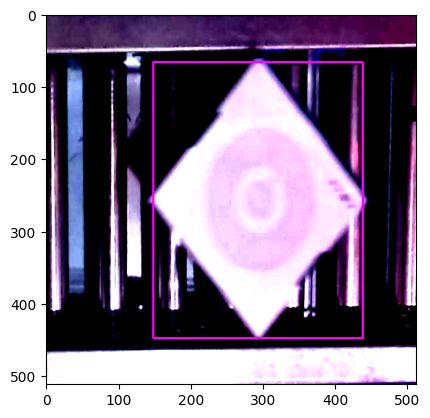

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


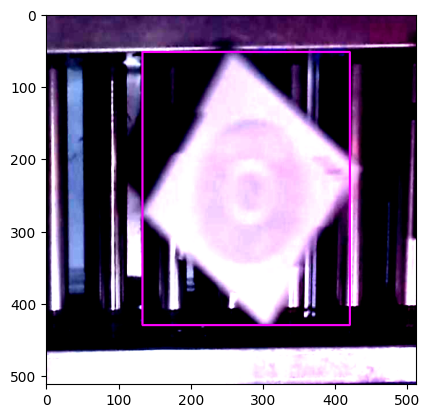

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


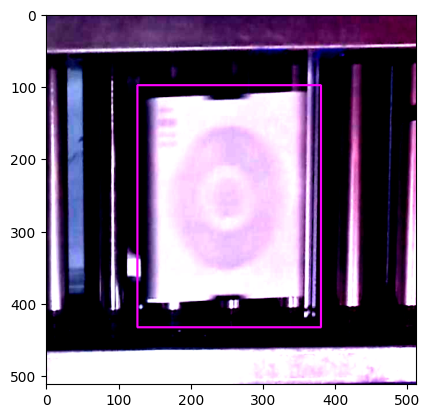

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


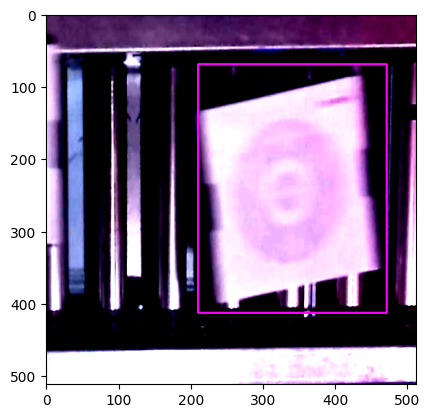

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


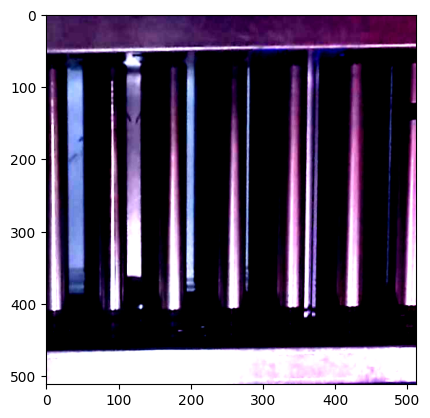

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


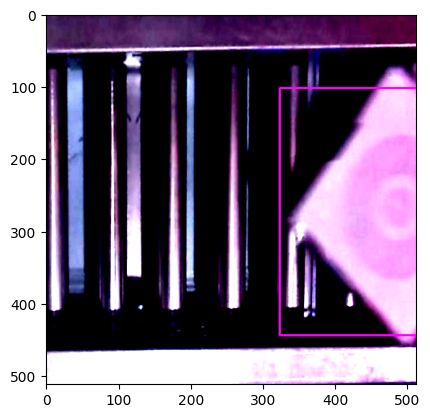

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


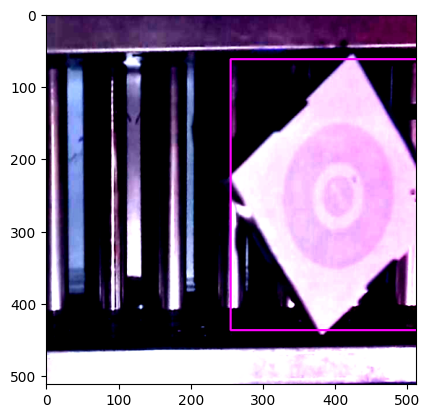

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


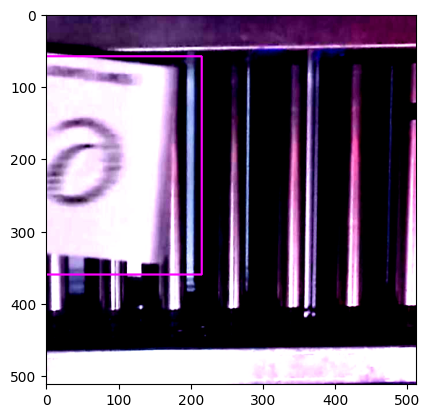

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


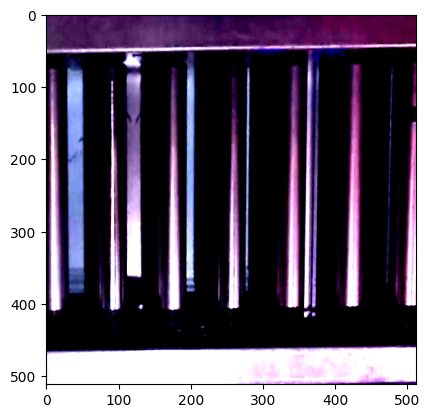

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


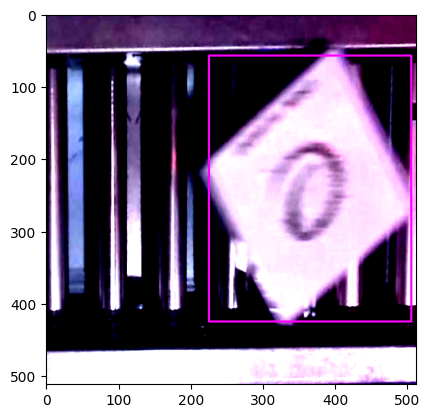

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


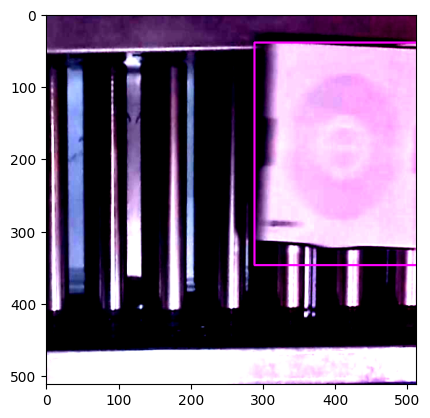

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


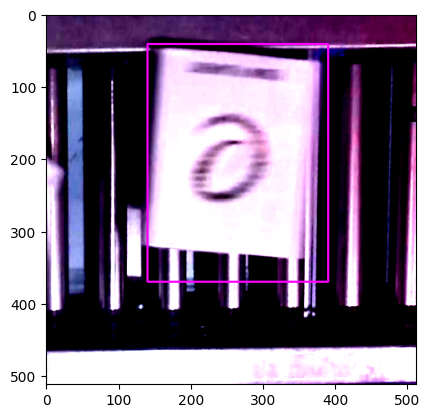

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


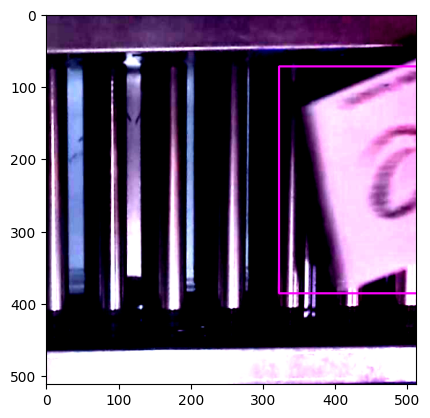

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


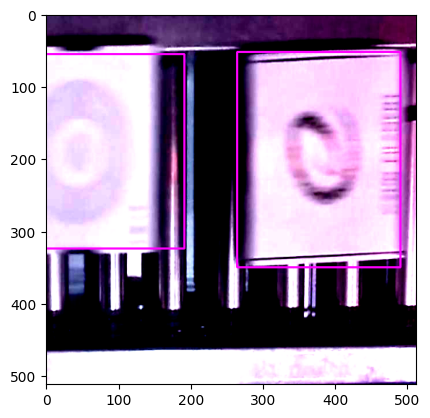

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


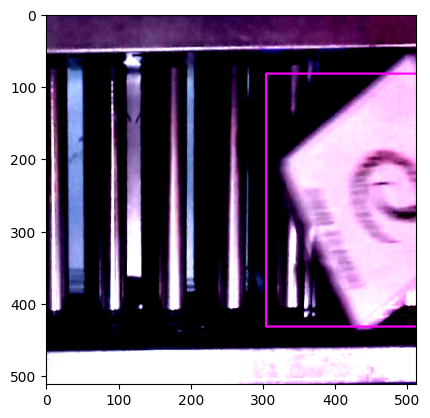

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


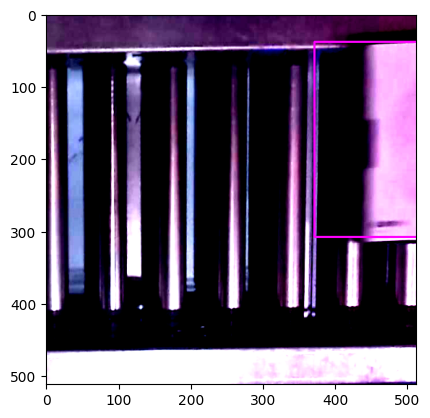

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


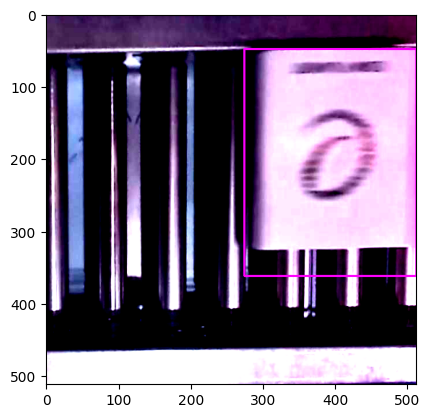

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


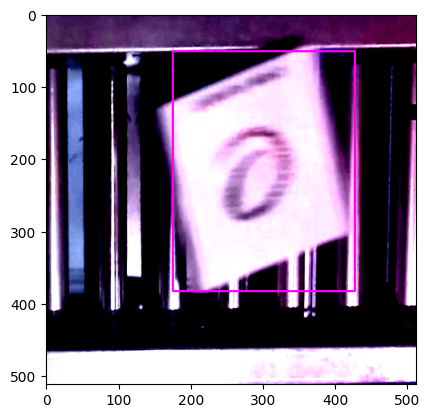

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


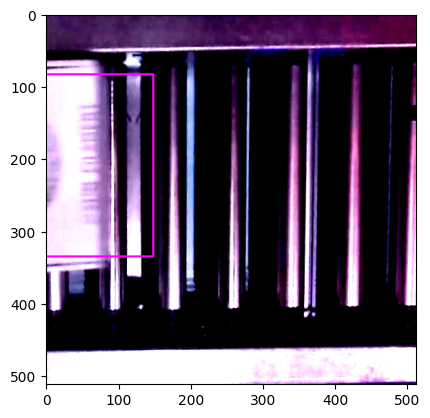

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


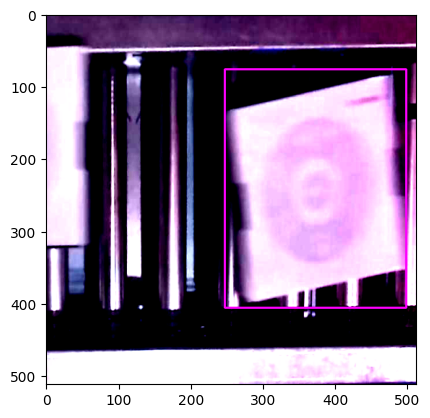

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


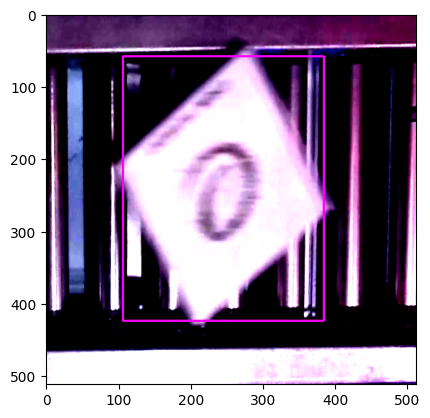

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


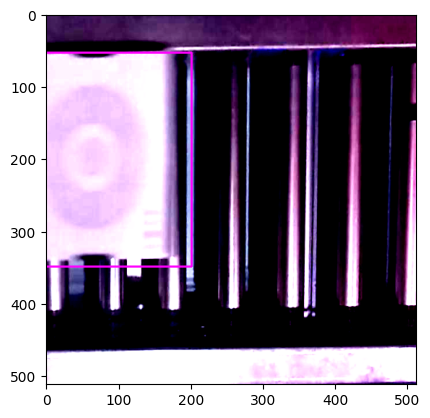

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


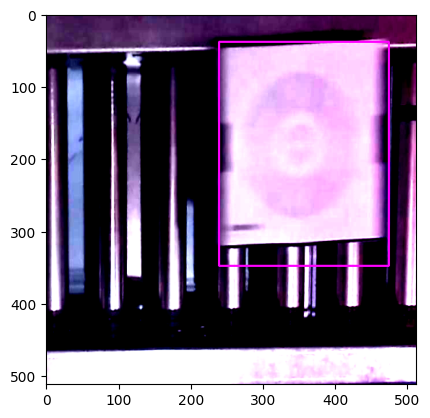

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


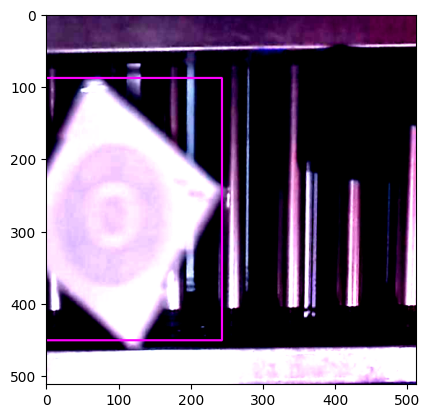

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


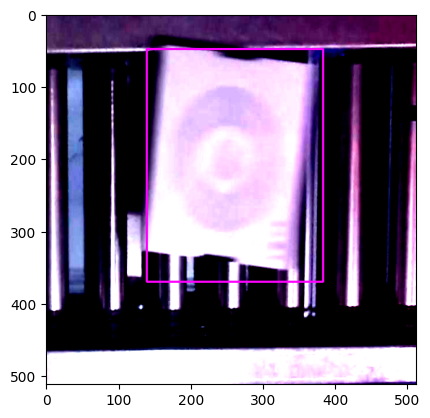

(512, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


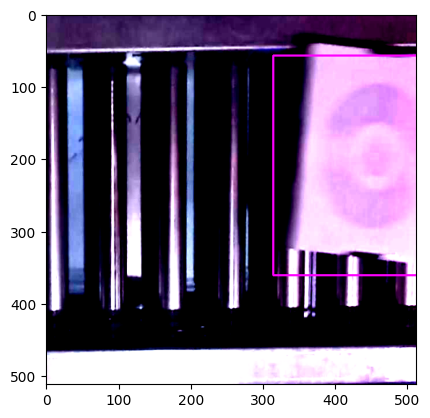

IndexError: list index out of range

In [47]:
for id in range(90):
    img, hm_gt, offset_gt, regr_gt,hm_all = valdataset[id]
    sample = np.transpose(img,(1,2,0)).copy()
    print(sample.shape)
    image_shape = np.array(np.shape(img)[0:2])
    img = torch.from_numpy(img)
    with torch.no_grad():
        hm, offset, wh = model(img.to(device).float().unsqueeze(0))
    offset = offset.cpu().numpy().squeeze(0)
    wh = wh.cpu().numpy().squeeze(0)
    hm = torch.sigmoid(hm)
    outputs = decode_bbox(hm,torch.tensor(wh[None]).cuda(),torch.tensor(offset[None]).cuda())
    results = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)
    try:
        top_label   = np.array(results[0][:, 5], dtype = 'int32')
        top_conf    = results[0][:, 4]
        top_boxes   = results[0][:, :4]
        for box in top_boxes:
            ymin = box[0]
            xmin = box[1] 
            ymax = box[2] 
            xmax = box[3] 

            xmin = int(xmin)
            ymin = int(ymin)
            xmax = int(xmax)
            ymax = int(ymax)

            cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)
    except:
        pass
    plt.imshow(sample)
    plt.show()

In [ ]:
"""
Ground Truth of Validation

"""

for id in range(90):
    img, hm_gt, offset_gt, regr_gt,hm_all = valdataset[id]
    sample = np.transpose(img,(1,2,0)).copy()
    print(sample.shape)
    image_shape = np.array(np.shape(img)[0:2])
    img = torch.from_numpy(img)
    with torch.no_grad():
        hm, offset, wh  = model(img.to(device).float().unsqueeze(0))
    offset = offset.cpu().numpy().squeeze(0)
    wh = wh.cpu().numpy().squeeze(0)
    hm = torch.tensor(hm_gt)
    outputs = decode_bbox(hm[None].cuda(),torch.tensor(regr_gt[None]).cuda(),torch.tensor(offset_gt[None]).cuda())
    results = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)
    top_label   = np.array(results[0][:, 5], dtype = 'int32')
    top_conf    = results[0][:, 4]
    top_boxes   = results[0][:, :4]
    print(top_boxes)
    for box in top_boxes:
        ymin = box[0]
        xmin = box[1] 
        ymax = box[2] 
        xmax = box[3] 

        xmin = int(xmin)
        ymin = int(ymin)
        xmax = int(xmax)
        ymax = int(ymax)

        cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)
    plt.imshow(sample)
    plt.show()